# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета. 

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Результаты работы также должны появиться в базе данных, так как они будут переданы аналитикам компании. В результате вашей работы в базе должна быть информация от вас в двух таблицах (смотри задание в конце нотубука). Наличие информации о ваших результатах в первой таблице: student_results - блокирующее задание, без его выполнения за домашнее задание ставится 0.

Продуктивной и интересной вам работы!

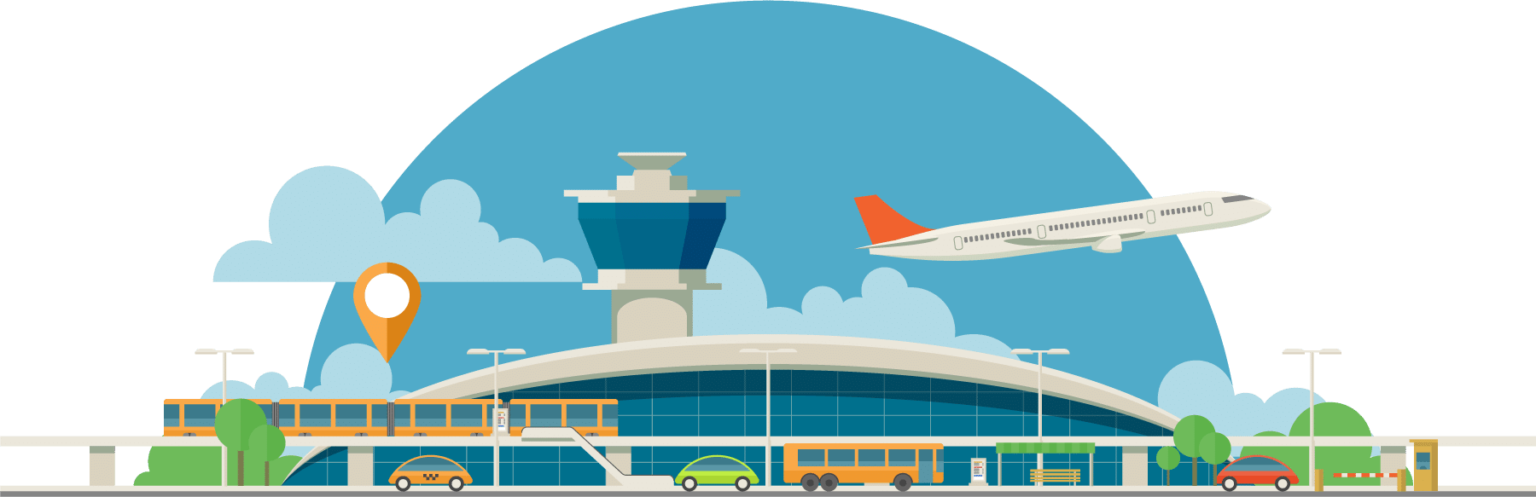

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода.

> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [1]:
# !pip install catboost
# !pip install mlxtend --upgrade
# !pip install optuna
# !pip install lime
# !pip install shap
# !pip install eli5
# !pip install missingno
# !pip install psycopg2-binary

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [621]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions 
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel, RFECV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

import eli5
from eli5.sklearn.permutation_importance import PermutationImportance
import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)


# Data Prep & EDA (2.5 балла + 0.25)

## Загрузка и предобработка данных (1.5 балла)

In [4]:
# !mkdir -p ~/.postgresql && \
# wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
#     --output-document ~/.postgresql/root.crt && \
# chmod 0600 ~/.postgresql/root.crt

(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycog2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно. 

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

### Схема БД

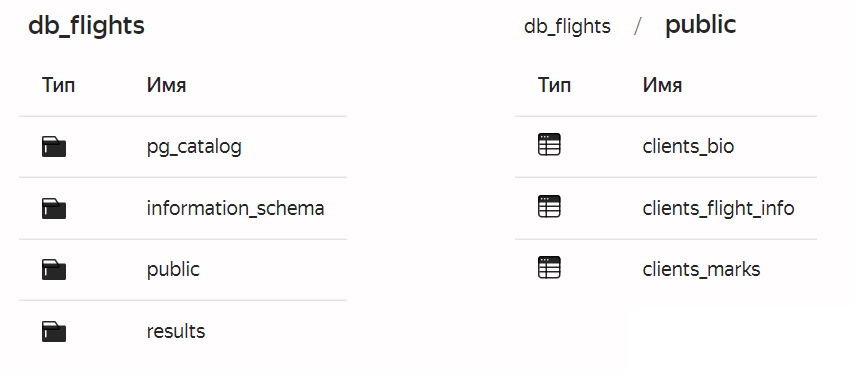

In [5]:
# your code below
def get_table_columns_by_name(conn: psycopg2.extensions.connection, name: str):
    with conn.cursor() as cur:
        cur.execute(f"select column_name from information_schema.columns where table_name = '{name}';")
        columns = cur.fetchall()
        return ['"' + i[0] + '"' for i in columns if i[0] != 'id']
    

with psycopg2.connect(host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net', 
                      port=6432, 
                      sslmode='verify-full', 
                      dbname='db_flights', 
                      user='mlhs_student', 
                      password='mlhs_student', 
                      target_session_attrs='read-write') as conn:

    columns = []
    for table in ('clients_bio', 'clients_flight_info', 'clients_marks'):
        table_columns = get_table_columns_by_name(conn, table)
        columns.extend(table_columns)
    
    columns.insert(0, 'b.id')
    query = (f'select {", ".join(columns)} from clients_bio b '
             'left join clients_flight_info f on b.id = f.id '
             'left join clients_marks m on b.id = m.id')
    
    df = pd.read_sql_query(query, conn).set_index('id')

In [6]:
df = df.sort_index().reset_index(drop=True)

In [7]:
assert df.shape == (129_549, 23)

In [8]:
# df.to_csv('df.csv', sep=';', index=False)

In [9]:
# df = pd.read_csv('df.csv', sep=';')

In [10]:
df.replace({'nan': np.nan}, inplace=True)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [11]:
# your code below
# Чтение из БД не сохранило исходные типы данных, теперь у меня все object
# Найду первую запись без пропусков, чтобы определить какие признаки в выборке числовые

num_feats = []

for idx in df.index:
    if df.loc[idx].isna().sum() == 0:
        break

for col, val in df.loc[idx].to_dict().items():
    if val[0].isdigit():
        num_feats.append(col)

for col in num_feats:
    df[col] = df[col].astype(float)

(0.25 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

<AxesSubplot:>

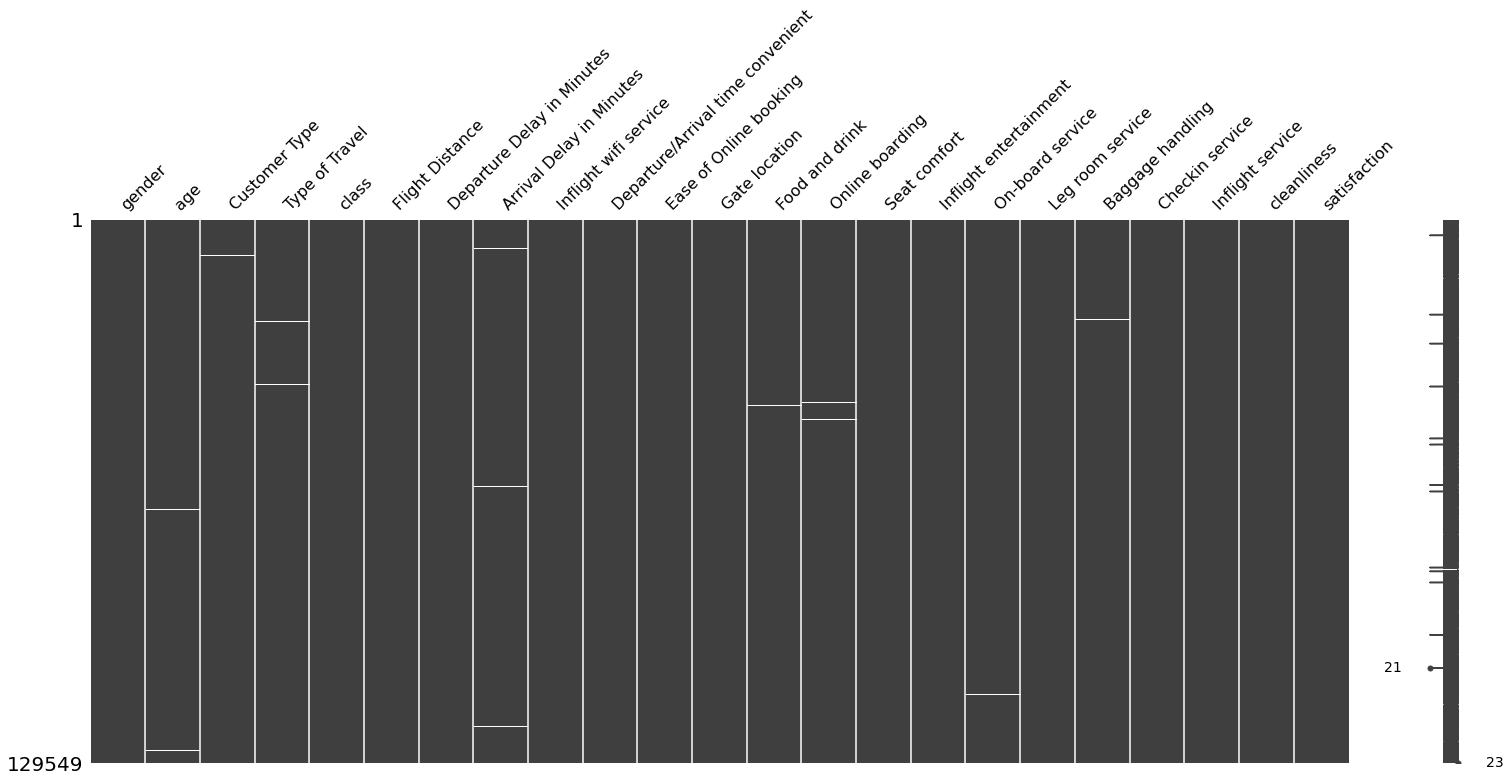

In [12]:
# your code below
missingno.matrix(df)

<AxesSubplot:>

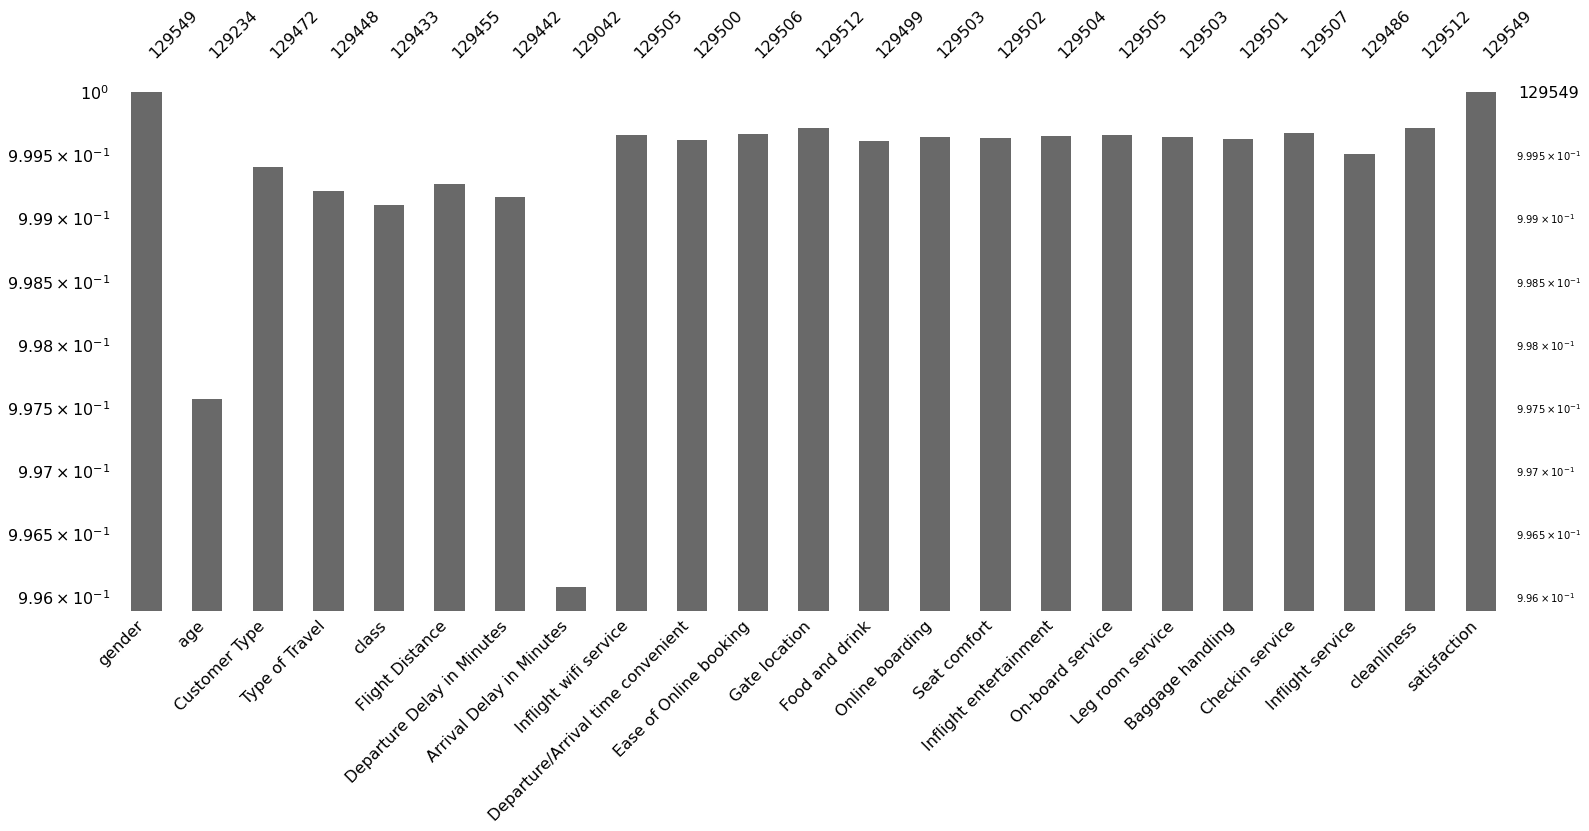

In [13]:
missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [14]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
0         Male  48.0  disloyal Customer  Business travel  Business   
1       Female  35.0     Loyal Customer  Business travel  Business   
2         Male  41.0     Loyal Customer  Business travel  Business   
3         Male  50.0     Loyal Customer  Business travel  Business   
4       Female  49.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129542  Female  28.0     Loyal Customer  Personal Travel  Eco Plus   
129543  Female  55.0     Loyal Customer  Personal Travel  Eco Plus   
129546    Male  42.0     Loyal Customer  Personal Travel  Eco Plus   
129547    Male  50.0     Loyal Customer  Personal Travel  Eco Plus   
129548  Female  20.0     Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
0                 821.0                         2.0                       5.0   
1                 821.0                        26.0                      39.0   
2                 853.0                         0.0                       0.0   
3                1905.0                         0.0                       0.0   
4                3470.0                         0.0                       1.0   
...                 ...                         ...                       ...   
129542            337.0                         0.0                       0.0   
129543            308.0                         0.0                       0.0   
129546            337.0                         6.0                      14.0   
129547            337.0                        31.0                      22.0   
129548            337.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
0                         3.0                                3.0  ...   
1                         2.0                                2.0  ...   
2                         4.0                                4.0  ...   
3                         2.0                                2.0  ...   
4                         3.0                                3.0  ...   
...                       ...                                ...  ...   
129542                    4.0                                2.0  ...   
129543                    3.0                                4.0  ...   
129546                    2.0                                5.0  ...   
129547                    5.0                                4.0  ...   
129548                    3.0                                1.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
0                   3.0           5.0                     5.0   
1                   5.0           4.0                     5.0   
2                   5.0           5.0                     3.0   
3                   4.0           5.0                     5.0   
4                   5.0           4.0                     3.0   
...                 ...           ...                     ...   
129542              4.0           3.0                     3.0   
129543              4.0           3.0                     4.0   
129546              2.0           3.0                     3.0   
129547              4.0           4.0                     3.0   
129548              3.0           2.0                     2.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                    3.0               2.0               5.0              4.0   
1                    5.0               5.0               5.0              3.0   
2                    3.0               3.0               3.0              4.0   
3                    5.0               5.0               5.0              3.0   
4                    3.0               4.0               3.0              3.0   
...                  ...               ...        

In [15]:
assert df_train.shape == (103_644, 23)

In [16]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age      Customer Type   Type of Travel     class  \
16      Female  48.0     Loyal Customer  Personal Travel       Eco   
19      Female  42.0     Loyal Customer  Personal Travel       Eco   
34        Male  39.0     Loyal Customer  Business travel  Business   
43        Male  51.0     Loyal Customer  Business travel  Business   
48        Male  20.0  disloyal Customer  Business travel       Eco   
...        ...   ...                ...              ...       ...   
129515  Female  16.0     Loyal Customer  Personal Travel       Eco   
129536    Male  47.0     Loyal Customer  Business travel  Eco Plus   
129540  Female  32.0     Loyal Customer  Business travel  Eco Plus   
129544    Male  28.0     Loyal Customer  Personal Travel  Eco Plus   
129545    Male  41.0     Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
16                821.0                         0.0                       0.0   
19                821.0                         4.0                       0.0   
34               1672.0                        23.0                      17.0   
43               2077.0                         0.0                       1.0   
48                108.0                         0.0                      29.0   
...                 ...                         ...                       ...   
129515            337.0                         0.0                       0.0   
129536            447.0                         0.0                       0.0   
129540            337.0                         0.0                       1.0   
129544            447.0                         2.0                       3.0   
129545            308.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
16                        2.0                                3.0  ...   
19                        3.0                                3.0  ...   
34                        2.0                                2.0  ...   
43                        4.0                                1.0  ...   
48                        4.0                                5.0  ...   
...                       ...                                ...  ...   
129515                    0.0                                4.0  ...   
129536                    3.0                                4.0  ...   
129540                    4.0                                2.0  ...   
129544                    4.0                                4.0  ...   
129545                    3.0                                5.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
16                 1.0              5.0           1.0                     5.0   
19                 1.0              3.0           4.0                     1.0   
34                 5.0              4.0           5.0                     3.0   
43                 2.0              5.0           5.0                     5.0   
48                 5.0              4.0           3.0                     5.0   
...                ...              ...           ...                     ...   
129515             3.0              0.0           3.0                     3.0   
129536             4.0              3.0           4.0                     4.0   
129540             4.0              4.0           4.0                     4.0   
129544             4.0              4.0           1.0                     4.0   
129545             2.0              3.0           2.0                     2.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
16                   5.0               2.0               5.0              5.0   
19                   1.0               3.0               1.0              3.0   
34                   3.0               4.0               5.0              5.0   
43                  

In [17]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [18]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), 
                                                  df_train.satisfaction, test_size=0.3, random_state=42)

In [19]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые. 

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [20]:
# your code below
# Я хотел сделать один экземпляр импьютера, но он возвращает np.array, при создании pd.DataFrame из него теряются типы данных

imputers = {}

for col in X_train.columns:
    mode_imputer = SimpleImputer(strategy='most_frequent', )
    X_train[col] = mode_imputer.fit_transform(X_train[[col]])
    X_val[col] = mode_imputer.transform(X_val[[col]])
    df_test[col] = mode_imputer.transform(df_test[[col]])
    
    imputers[col] = mode_imputer

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [21]:
# the place for you to code

X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.083666      1338.222261                   15.642591   
std       20.355546      4838.640464                   67.829985   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       842.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      612.000000    328510.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.381116               2.735603   
std                  100.546087               1.366913   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.063556                2.760744   
std                             1.556199                1.416293   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               36.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.981792        3.208132         3.259821      3.444328   
std         1.302569        1.357203         1.393320      1.344373   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       45.000000        40.000000     36.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362660          3.382977          3.355093   
std                  1.368691          1.334893          1.371754   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.633770         3.311647          3.644383      3.289690  
std            1.234864         1.311884          1.215434      1.345367  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

In [22]:
X_train.select_dtypes(include='object').describe()

gender   Customer Type   Type of Travel     class
count    72550           72550            72550     72550
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36738           59364            50046     34639

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

### Сложно сказать что-то конкретное, кажется почти во всех признаках есть выбросы, и у большинства не совпадает среднее и медиана, то есть в распределениях присутствуют хвосты



(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах.</font> Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [23]:
# place for you to code
quantiles = {}

for col in num_feats:
    quantiles[col] = X_train[col].quantile(0.996)

for col, quantile in quantiles.items():
    X_train = X_train[X_train[col] <= quantile]
    X_val = X_val[X_val[col] <= quantile]
#     df_test = df_test[df_test[col] <= quantile]

In [24]:
y_train = X_train.join(y_train)['satisfaction']
y_val = X_val.join(y_val)['satisfaction']

In [25]:
X_train.shape, X_val.shape, df_test.shape

((71369, 22), (30591, 22), (25905, 22))

In [26]:
assert X_train.shape == (71_369, 22)
# assert X_val.shape == (30_609, 22)
assert df_test.shape == (25_905, 22)

## EDA (1 балл + 0.25)

Создадим переменные с перечислениями столбцов разного типа

In [27]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols)) 
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [28]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [29]:
from typing import List

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [30]:
def plot_ordinal(cols: List[str], df: pd.DataFrame, y: str):
    """Draws countplots for all columns in 'cols' with informative title"""
    fig, axes = plt.subplots(len(cols), figsize=(8, len(cols) * 7))
    for ax, col in zip(axes, cols):
        ax.set_title(col + ' distribution')
        sns.countplot(ax=ax, data=df.join(y, how='left'), x=col, hue='satisfaction')

In [31]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row 
    for all columns in 'cols' with informative title 
    """
    data = df.join(y, how='left')
    
    fig, axes = plt.subplots(len(cols), 2, figsize=(10, len(cols) * 7))
    for ax, col in zip(axes, cols):
        ax[0].set_title(col + ' distribution')
        sns.kdeplot(data=data, x=col, ax=ax[0], hue='satisfaction')
        
        ax[1].set_title(col + ' boxplot by target')
        sns.boxplot(data=data, x=col, ax=ax[1], y='satisfaction')

In [32]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    fig, axes = plt.subplots(len(cols), figsize=(8, len(cols) * 7))
    for ax, col in zip(axes, cols):
        ax.set_title(col + ' distribution')
        sns.countplot(ax=ax, data=df.join(y, how='left'), x=col, hue='satisfaction')

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

In [33]:
plot_continuous(continuous_cols, X_train, y_train)

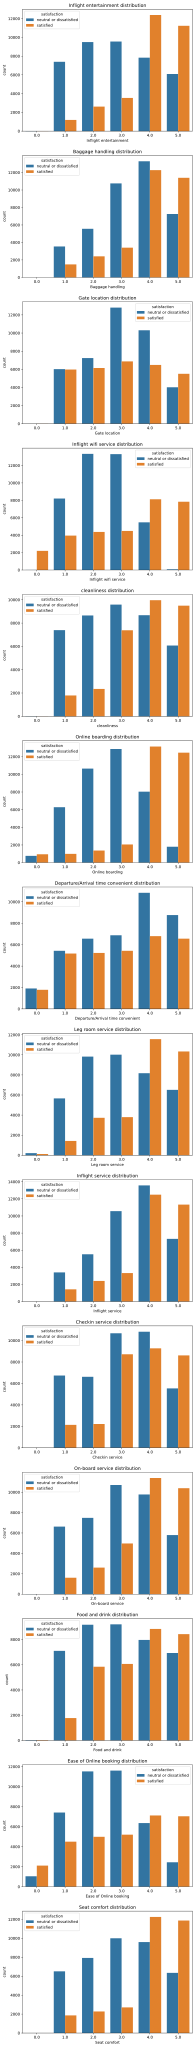

In [34]:
plot_ordinal(ordinal_cols, X_train, y_train)

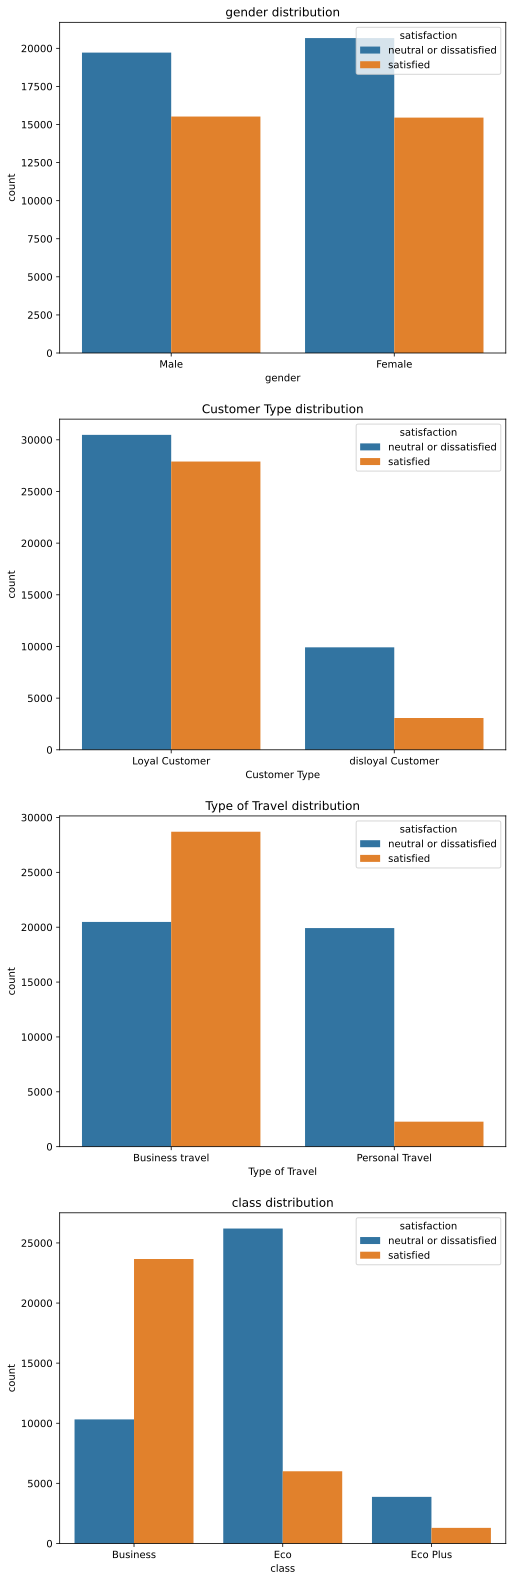

In [35]:
plot_categorical(categorical_cols, X_train, y_train)

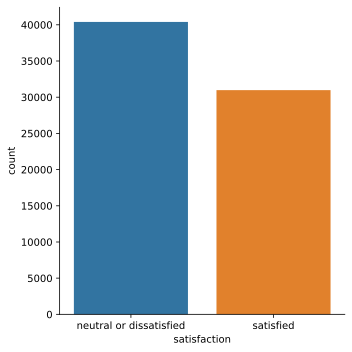

In [36]:
# visualize y_train
sns.catplot(y_train.reset_index(), x="satisfaction", kind="count")

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

#### Заметно, что распределения возраста отличаются для довольных и недовольных пассажиров
#### Классы слегка не сбалансированы, думаю это не станет проблемой
#### Континуальные признаки (если я правильно понял, что это непрерывные признаки): возраст, дальность полета, задержка вылета и прилета

(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

In [37]:
ordinal_cols

['Inflight entertainment',
 'Baggage handling',
 'Gate location',
 'Inflight wifi service',
 'cleanliness',
 'Online boarding',
 'Departure/Arrival time convenient',
 'Leg room service',
 'Inflight service',
 'Checkin service',
 'On-board service',
 'Food and drink',
 'Ease of Online booking',
 'Seat comfort']

In [38]:
continuous_cols

['age',
 'Flight Distance',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes']

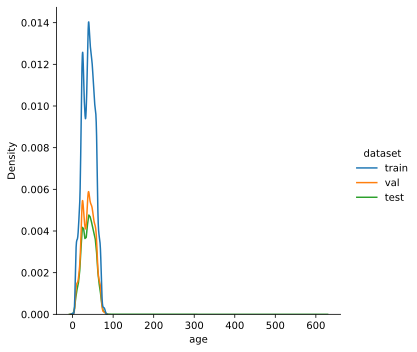

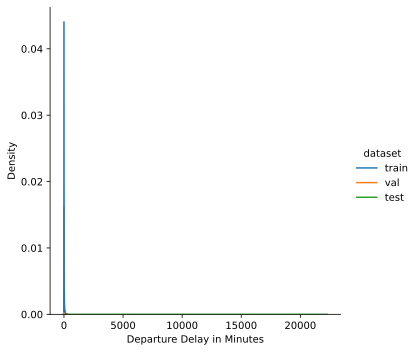

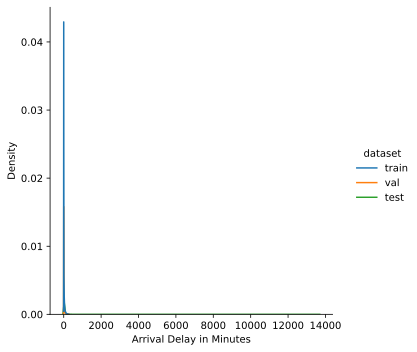

In [39]:
# your code below
X_train_copy = X_train.copy()
df_test_copy = df_test.copy()
X_val_copy = X_val.copy()

X_train_copy['dataset'] = 'train'
X_val_copy['dataset'] = 'val'
df_test_copy['dataset'] = 'test'

mixed_df = pd.concat([X_train_copy, X_val_copy, df_test_copy], axis=0)

sns.displot(mixed_df, x='age', hue='dataset', kind='kde')
sns.displot(mixed_df, x='Departure Delay in Minutes', hue='dataset', kind='kde')
sns.displot(mixed_df, x='Arrival Delay in Minutes', hue='dataset', kind='kde')

<AxesSubplot:xlabel='Inflight service', ylabel='count'>

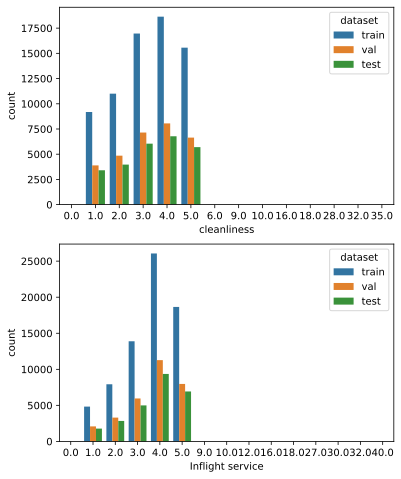

In [40]:
_, axes = plt.subplots(2, 1, figsize=(6, 8))
sns.countplot(mixed_df, x='cleanliness', hue='dataset', ax=axes[0])
sns.countplot(mixed_df, x='Inflight service', hue='dataset', ax=axes[1])

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [41]:
# your code

for col in ['Departure Delay in Minutes', 'Arrival Delay in Minutes']:
    X_train[col] = np.log1p(X_train[col])
    X_val[col] = np.log1p(X_val[col])
    df_test[col] = np.log1p(df_test[col])

Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

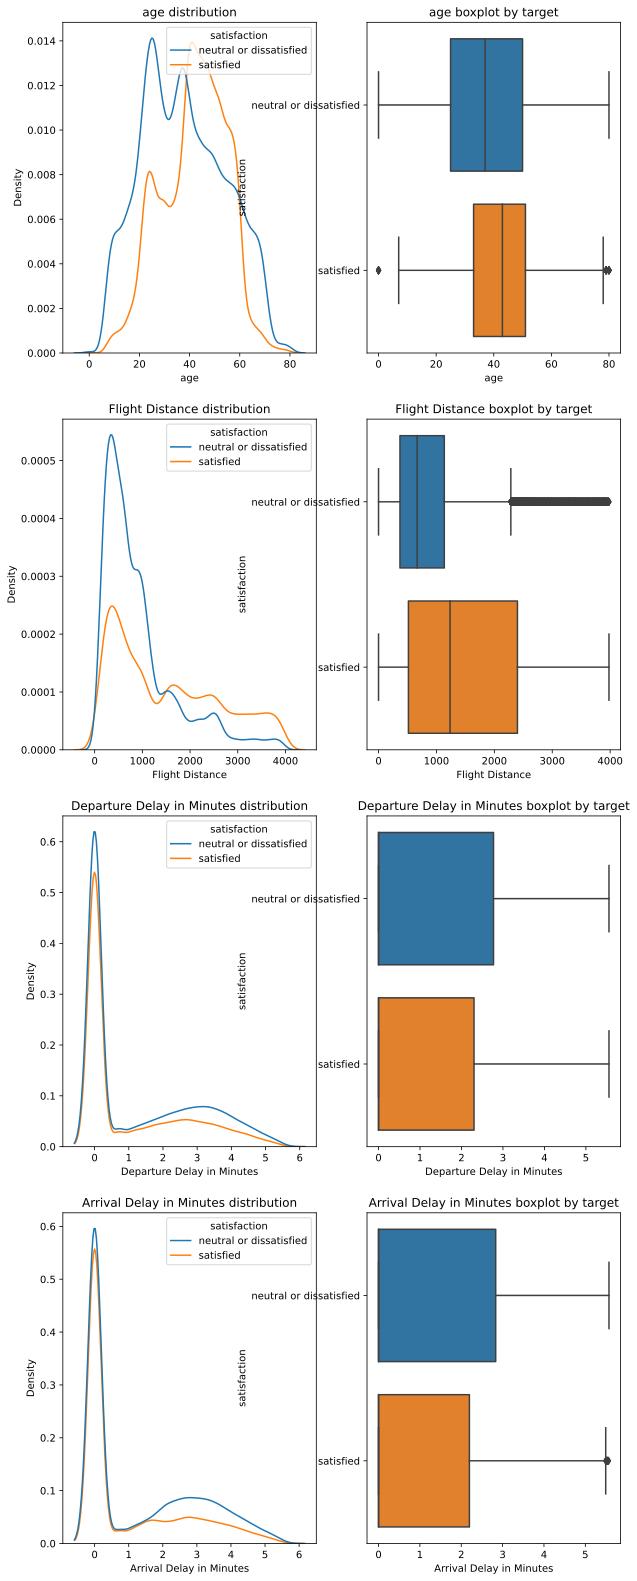

In [43]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [45]:
# your code
y_train.replace({'satisfied': 1, 'neutral or dissatisfied': 0}, inplace=True)
y_val.replace({'satisfied': 1, 'neutral or dissatisfied': 0}, inplace=True)

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

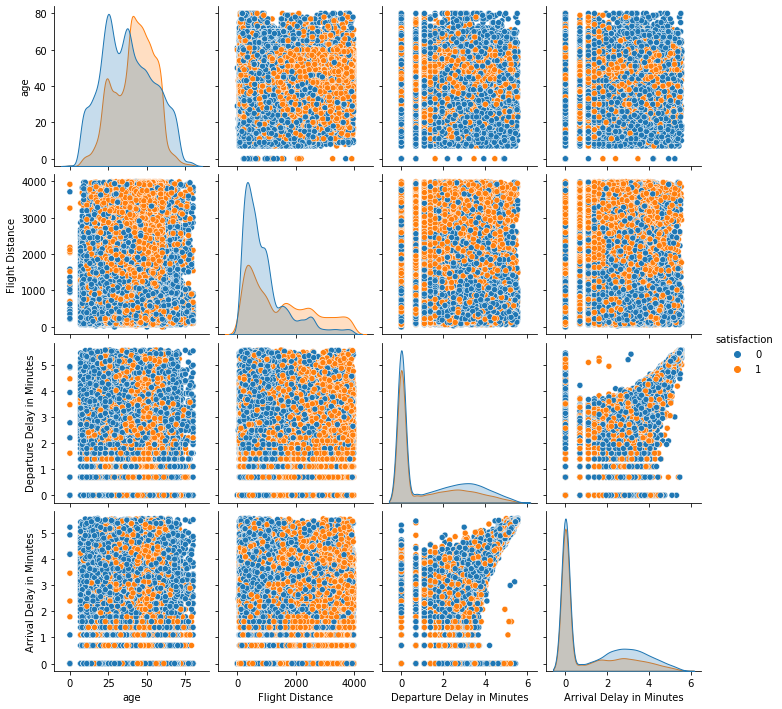

In [46]:
# your code
set_matplotlib_formats('png', quality=90)
sns.pairplot(X_train[continuous_cols].join(y_train), hue='satisfaction')

<AxesSubplot:>

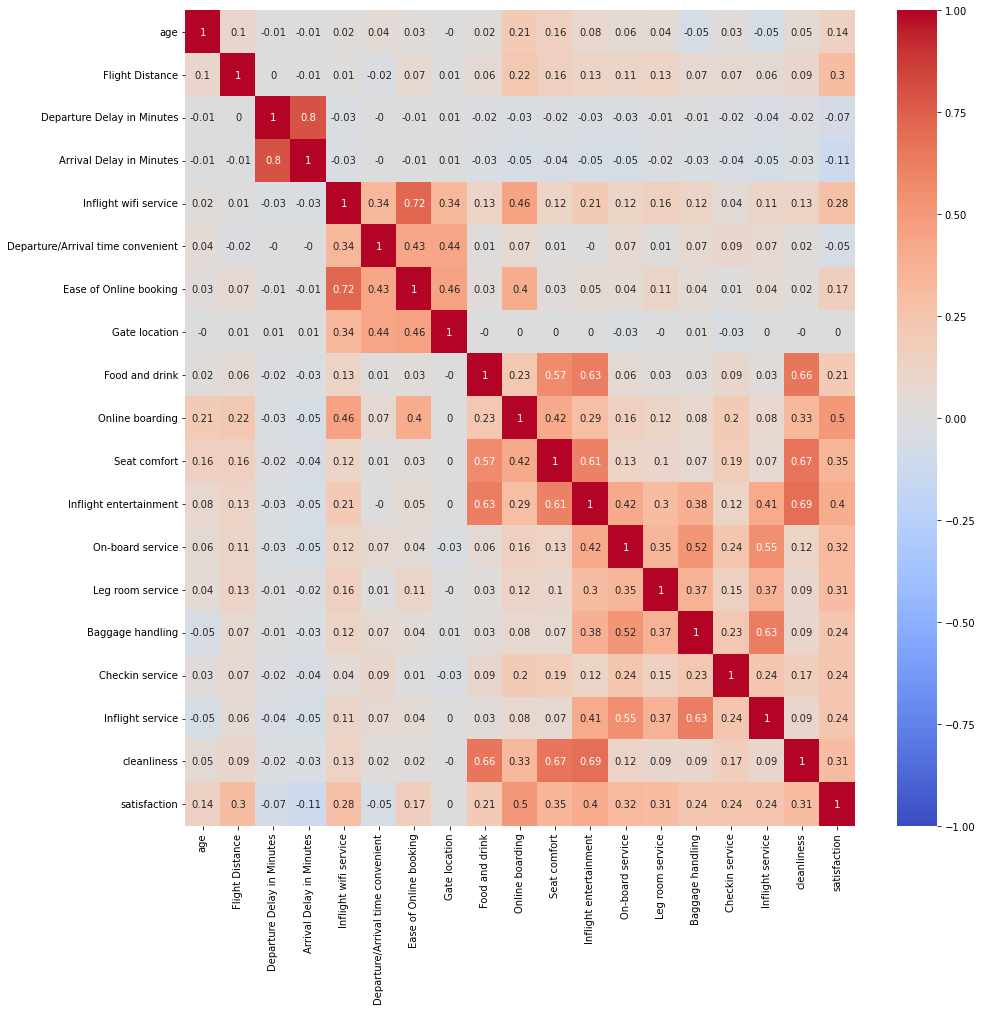

In [48]:
# code below
fig = plt.figure(figsize=(15, 15))
sns.heatmap(X_train.join(y_train).corr().round(2), annot = True, vmin=-1, vmax=1, center= 0, cmap='coolwarm')

<font color='#9933CC'>Отобразите тепловую карту корреляций признаков и таргета</font>

Видим, что с целевой переменной ни у одного признака нет выраженной корреляции. Самая большая у 'Online boarding'. Дальше проверим, информативен ли этот признак для предсказания удовлетворенности

<img src='https://mobimg.b-cdn.net/v3/fetch/fe/fe22186dba2df35f07573604aa8a0e63.jpeg?w=1470&r=0.5625' height=500px>

# Decision Tree (1.75 балла)

(0.25 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [94]:
# your code below

ohe_tree = OneHotEncoder()
tree_model = DecisionTreeClassifier()

# cat_feats_transformer = ColumnTransformer([
#     ('one_hot_encoder', ohe_tree, categorical_cols)
# ], remainder='passthrough')

# tree_pipeline = Pipeline(steps=[
#     ('cat_feats_transformer', cat_feats_transformer),
#     ('classifier', tree_model)
# ])
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)

y_train.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)

X_train_ohe = X_train.drop(categorical_cols, axis=1).join(
    pd.DataFrame(ohe_tree.fit_transform(X_train[categorical_cols]).toarray(), 
                 columns=ohe_tree.get_feature_names_out()))

X_val_ohe = X_val.drop(categorical_cols, axis=1).join(
    pd.DataFrame(ohe_tree.transform(X_val[categorical_cols]).toarray(), 
                 columns=ohe_tree.get_feature_names_out()))

In [98]:
X_train_ohe.head()

age  Flight Distance  Departure Delay in Minutes  \
0  38.0           3664.0                    3.091042   
1  37.0           1217.0                    1.386294   
2  41.0            240.0                    0.000000   
3  56.0           1061.0                    0.000000   
4  27.0           1635.0                    2.639057   

   Arrival Delay in Minutes  Inflight wifi service  \
0                  3.135494                    2.0   
1                  0.693147                    2.0   
2                  0.000000                    2.0   
3                  0.000000                    4.0   
4                  3.784190                    3.0   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                4.0                     4.0            4.0   
1                                1.0                     2.0            3.0   
2                                2.0                     2.0            2.0   
3                                3.0                     4.0            4.0   
4                                2.0                     2.0            2.0   

   Food and drink  Online boarding  ...  cleanliness  gender_Female  \
0             5.0              3.0  ...          4.0            0.0   
1             5.0              2.0  ...          5.0            1.0   
2             3.0              4.0  ...          4.0            0.0   
3             2.0              4.0  ...          2.0            0.0   
4             3.0              3.0  ...          3.0            0.0   

   gender_Male  Customer Type_Loyal Customer  Customer Type_disloyal Customer  \
0          1.0                           1.0                              0.0   
1          0.0                           1.0                              0.0   
2          1.0                           1.0                              0.0   
3          1.0                           1.0                              0.0   
4          1.0                           1.0                              0.0   

   Type of Travel_Business travel  Type of Travel_Personal Travel  \
0                             1.0                             0.0   
1                             0.0                             1.0   
2                             1.0                             0.0   
3                             0.0                             1.0   
4                             1.0                             0.0   

   class_Business  class_Eco  class_Eco Plus  
0             1.0        0.0             0.0  
1             0.0        1.0             0.0  
2             1.0        0.0             0.0  
3             0.0        1.0             0.0  
4             0.0        1.0             0.0  

[5 rows x 27 columns]

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для теста

In [99]:
# code here

tree_model.fit(X_train_ohe, y_train)
pred_val = tree_model.predict(X_val_ohe)

accuracy_score(y_val, pred_val)

# tree_pipeline.fit(X_train_ohe, y_train)
# pred_test = tree_pipeline.predict(X_val_ohe)

0.942630185348632

## Деревья решений. Теоретическая вставка

(0.25 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [100]:
# change *params into what needs to be there by task condition
params = {
    'estimator': tree_model,
    'X_train': X_train_ohe.values,
    'y_train': y_train.values,
    'X_test': X_val_ohe.values,
    'y_test': y_val.values,
    'loss': '0-1_loss',
    'random_seed': 42
}

error_dt, bias_dt, var_dt = bias_variance_decomp(**params)
error_dt, bias_dt, var_dt

(0.0590466150174888, 0.039815632048641754, 0.04272743617403811)

## Возвращение к задаче

(0.25 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

In [103]:
len(tree_model.feature_importances_), len(X_train_ohe.columns)

(27, 27)

<AxesSubplot:>

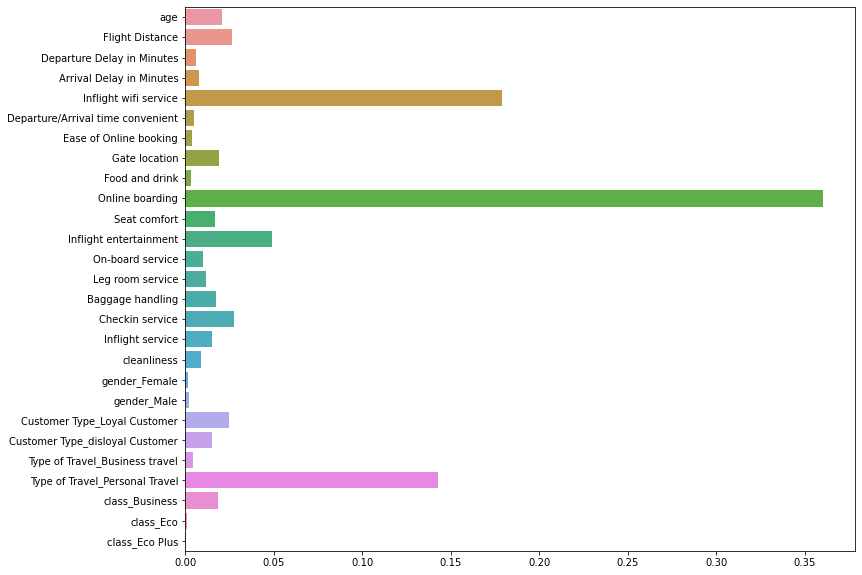

In [112]:
plt.figure(figsize=(12, 10))
sns.barplot(x=tree_model.feature_importances_, y=X_train_ohe.columns)

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

### Явно видно, что онлайн регистрация, качество вайфая в полете, и не в рамках командировки сильнее всего влияют на ответ модели

<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [116]:
print(f'depth is {tree_model.get_depth()}')
print(f'Number of leaves is {tree_model.get_n_leaves()}')

depth is 35
Number of leaves is 1992


<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [120]:
# the place for your solution

tree_depth_5 = DecisionTreeClassifier(max_depth=5)

tree_depth_5.fit(X_train[['Online boarding', 'Inflight wifi service']], y_train)
pred_val_depth_5 = tree_depth_5.predict(X_val[['Online boarding', 'Inflight wifi service']])

print(f'new accuracy = {accuracy_score(y_val, pred_val_depth_5)}')
print(f'accuracy decrease = {accuracy_score(y_val, pred_val) - accuracy_score(y_val, pred_val_depth_5)}')

new accuracy = 0.8217776470203655
accuracy decrease = 0.12085253832826648


(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

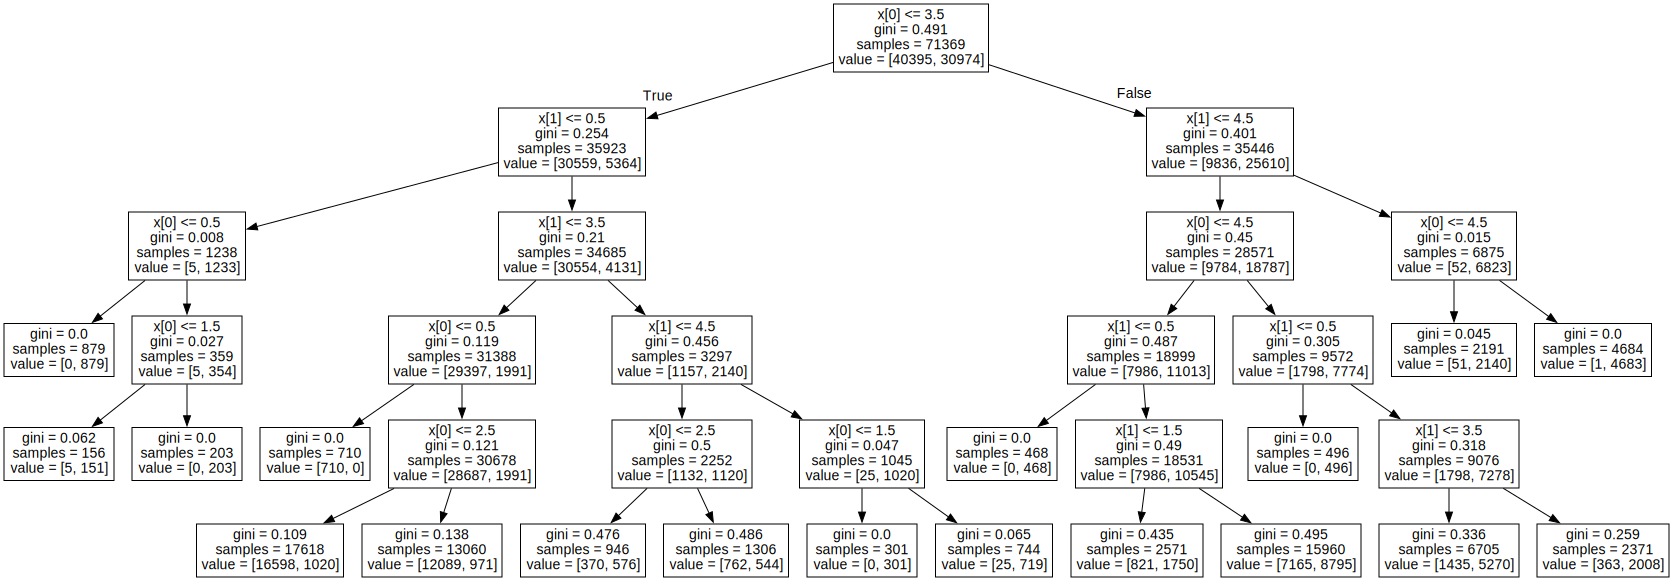

In [122]:
# feel free to google

Source(export_graphviz(tree_depth_5))

### Полагаю, потому что при выборе лучшего разбиения значения каждого признака сортируются, для подбора предиката проверяются значения посередине между соседними в отсортированном столбце. Например, если оказалось, что значения признака после сортировки [3, 4], то будем проверять значение предиката = 3.5

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договореённости) признаков</font>

In [127]:
# your code below

tree_model_cont_depth_5 = DecisionTreeClassifier(max_depth=5)
tree_model_cont_depth_5.fit(X_train[['age', 'Flight Distance']], y_train)
pred_val_cont_depth_5 = tree_model_cont_depth_5.predict(X_val[['age', 'Flight Distance']])

accuracy_score(y_val, pred_val_cont_depth_5)

0.6809519139616227

(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

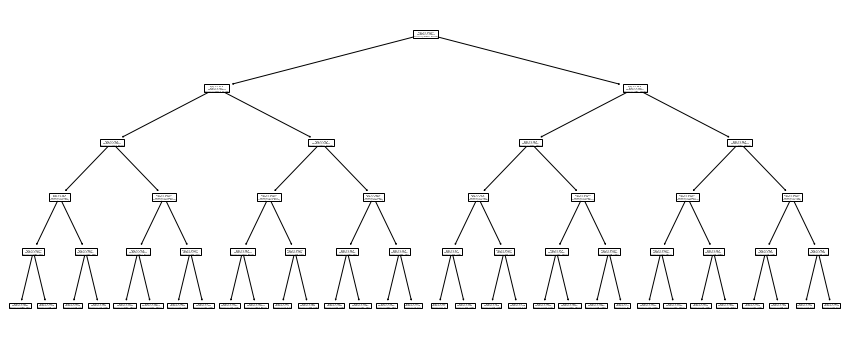

In [130]:
plt.figure(figsize=(15, 6))
plt.show(plot_tree(tree_model_cont_depth_5))

### Дерево получилось симметричным, это ожидаемо, ведь мы ограничивали глубину, а не число листов. Не совсем очевидно, хорошо это или плохо, наверное оно более переобученное, чем получилось бы при ограничении макс числа листов

(0.25 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

In [139]:
X_train.iloc[:100]

gender   age   Customer Type   Type of Travel     class  Flight Distance  \
0     Male  38.0  Loyal Customer  Business travel  Business           3664.0   
1   Female  37.0  Loyal Customer  Personal Travel       Eco           1217.0   
2     Male  41.0  Loyal Customer  Business travel  Business            240.0   
3     Male  56.0  Loyal Customer  Personal Travel       Eco           1061.0   
4     Male  27.0  Loyal Customer  Business travel       Eco           1635.0   
..     ...   ...             ...              ...       ...              ...   
95  Female  32.0  Loyal Customer  Business travel  Business            376.0   
96  Female  50.0  Loyal Customer  Business travel  Business           1670.0   
97    Male  25.0  Loyal Customer  Business travel  Eco Plus            587.0   
98  Female  49.0  Loyal Customer  Business travel  Business           3942.0   
99    Male  62.0  Loyal Customer  Personal Travel       Eco            528.0   

    Departure Delay in Minutes  Arrival Delay in Minutes  \
0                     3.091042                  3.135494   
1                     1.386294                  0.693147   
2                     0.000000                  0.000000   
3                     0.000000                  0.000000   
4                     2.639057                  3.784190   
..                         ...                       ...   
95                    1.609438                  1.609438   
96                    0.000000                  0.000000   
97                    2.890372                  3.218876   
98                    5.303305                  0.000000   
99                    1.386294                  0.000000   

    Inflight wifi service  Departure/Arrival time convenient  ...  \
0                     2.0                                4.0  ...   
1                     2.0                                1.0  ...   
2                     2.0                                2.0  ...   
3                     4.0                                3.0  ...   
4                     3.0                                2.0  ...   
..                    ...                                ...  ...   
95                    1.0                                1.0  ...   
96                    2.0                                2.0  ...   
97                    3.0                                1.0  ...   
98                    0.0                                0.0  ...   
99                    2.0                                4.0  ...   

    Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
0              5.0              3.0           3.0                     3.0   
1              5.0              2.0           5.0                     5.0   
2              3.0              4.0           5.0                     4.0   
3              2.0              4.0           2.0                     2.0   
4              3.0              3.0           3.0                     3.0   
..             ...              ...           ...                     ...   
95             5.0              5.0           5.0                     5.0   
96             3.0              5.0           5.0                     5.0   
97             3.0              3.0           2.0                     3.0   
98             2.0              5.0           5.0                     2.0   
99             4.0              2.0           4.0                     4.0   

    On-board service  Leg room service  Baggage handling  Checkin service  \
0                3.0               3.0               2.0              1.0   
1                3.0               2.0               4.0              2.0   
2                4.0               4.0               4.0              4.0   
3                2.0               3.0               2.0              4.0   
4                3.0               3.0               3.0              1.0   
..               ...               ...               ...              ...   
95               1.0         

<AxesSubplot:>

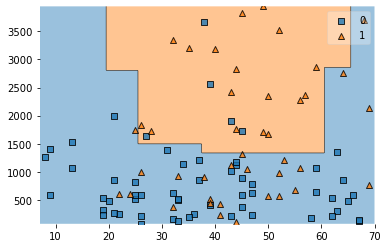

In [145]:
# your line of code
X_train_example = X_train[['age', 'Flight Distance']]

plot_decision_regions(X_train_example.iloc[:100].to_numpy(), 
                      y_train[:100].to_numpy(), 
                      clf=tree_model_cont_depth_5)

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

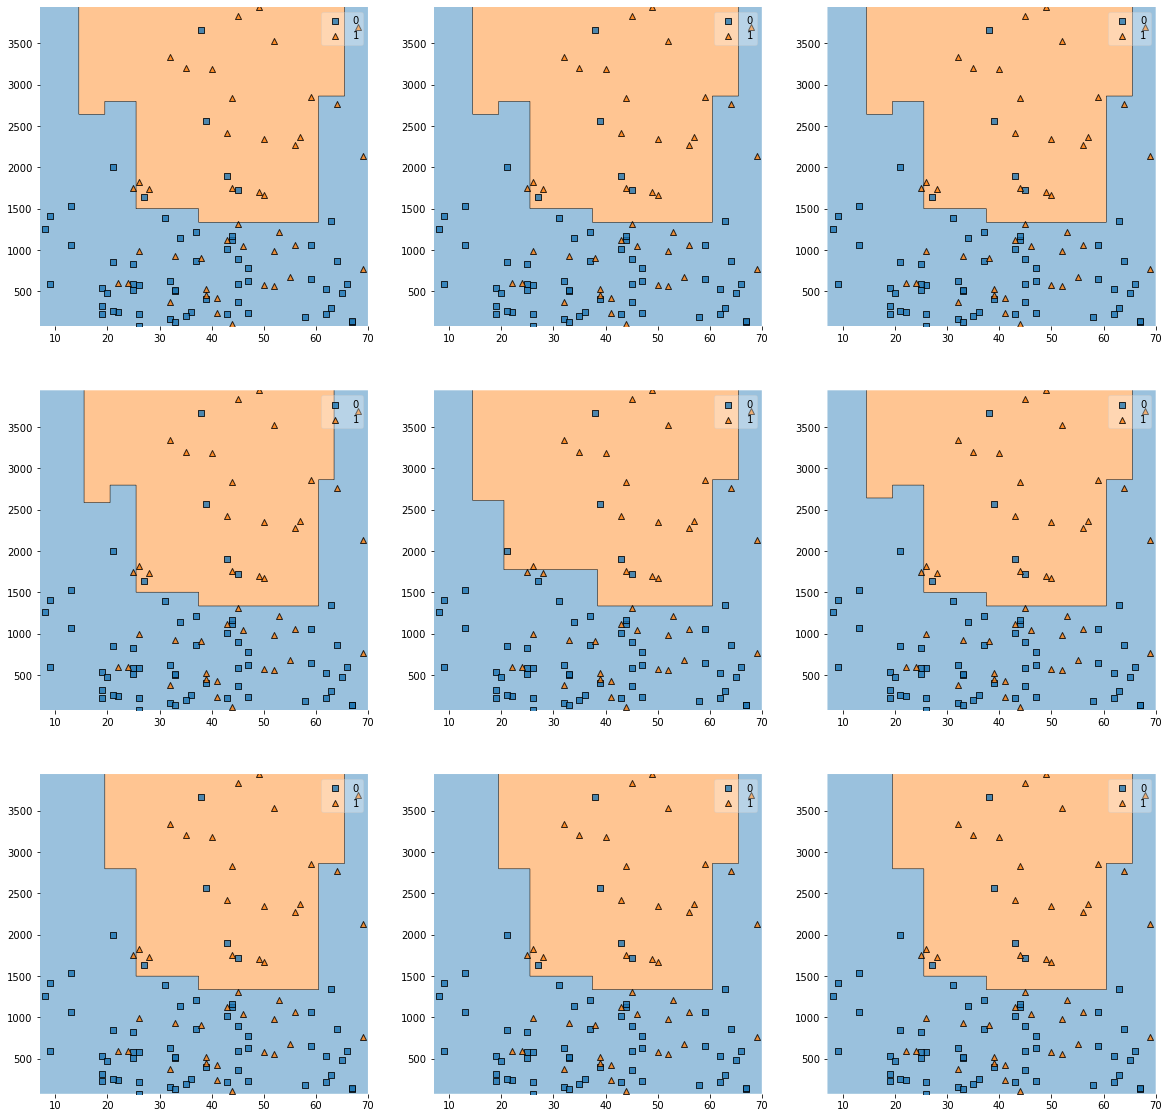

In [155]:
# change X_train_example to your equivalent

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False)

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [161]:
# change X_train_enc into your ohe-encoded train set

# %%time
X_train_enc = X_train_ohe
X_val_enc = X_val_ohe

depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

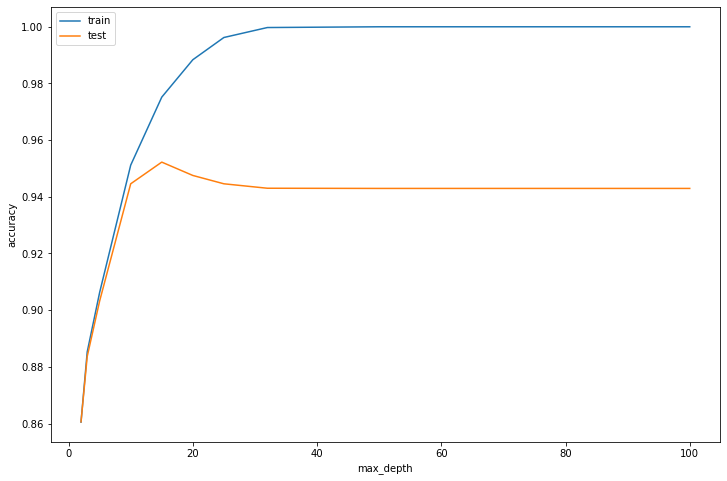

In [162]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.25 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font>. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [175]:
# you know what to do

params_grid = {
    'max_depth': [10, 20, 30],
    'max_leaf_nodes': [512, 2048], 
    'criterion': ['entropy', 'gini', 'log_loss']
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=params_grid, cv=3)

grid_search.fit(X_train_enc, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini', 'log_loss'],
                         'max_depth': [10, 20, 30],
                         'max_leaf_nodes': [512, 2048]})

In [176]:
grid_search.best_params_

{'criterion': 'log_loss', 'max_depth': 30, 'max_leaf_nodes': 512}

In [178]:
pred_val = grid_search.predict(X_val_ohe)
accuracy_score(y_val, pred_val)

0.957242326174365

### Качество получилось лучше, чем при дефолтных параметрах

<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [181]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

# Random Forest (2 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [183]:
# -__-

rf = RandomForestClassifier()

rf.fit(X_train_ohe, y_train)
pred_val = rf.predict(X_val_ohe)

accuracy_score(y_val, pred_val)

0.9621784184890981

(0.25 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

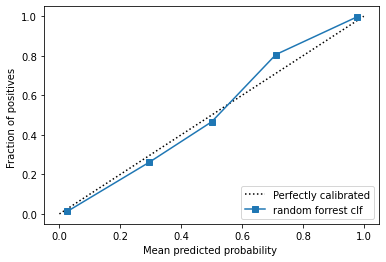

In [193]:
y_prob = rf.predict_proba(X_val_ohe)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_prob, n_bins=5)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob, estimator_name='random forrest clf')
disp.plot()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

### Нет, считается, что только логистическая регрессия предсказывает честные вероятности

<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

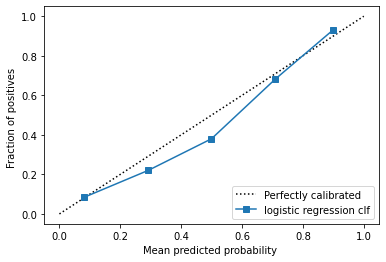

In [194]:
# --____--

log_reg = LogisticRegression()
log_reg.fit(X_train_ohe, y_train)

y_prob = log_reg.predict_proba(X_val_ohe)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_prob, n_bins=5)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob, estimator_name='logistic regression clf')
disp.plot()

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

### Функция ошибки log-loss выводится из метода максимального правдоподобия и устроена так, что классификатор выдает значения, которые называются логитами (натуральный логарифм отношения принадлежности объекта к 1 классу и принадлежности его к 0 классу)

$$a^*(x_i) = log_e(\frac{P(y=1|x_i)}{1 - P(y=1|x_i)})$$

### Когда мы применяем сигмоиду к логитам, то получаем настоящуие вероятности

$$a(x_i) = \frac{1}{1 + e^{-a^*(x_i)}} = P(y=1|x_i)$$

(0.25 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

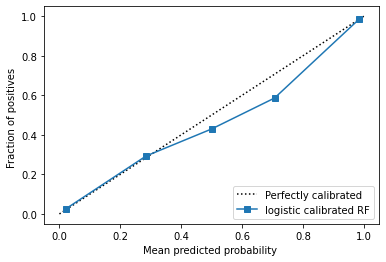

In [198]:
rf_log_calibrated = CalibratedClassifierCV(estimator=rf, method='sigmoid')

rf_log_calibrated.fit(X_train_ohe, y_train)

y_prob = rf_log_calibrated.predict_proba(X_val_ohe)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_prob, n_bins=5)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob, estimator_name='logistic calibrated RF')
disp.plot()

In [223]:
pred_val = rf_log_calibrated.predict(X_val_ohe)

accuracy_score(y_val, pred_val)

0.9609362230721454

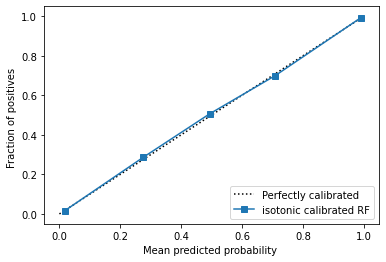

In [203]:
rf_iso_calibrated = CalibratedClassifierCV(estimator=rf, method='isotonic')

rf_iso_calibrated.fit(X_train_ohe, y_train)

y_prob = rf_iso_calibrated.predict_proba(X_val_ohe)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_prob, n_bins=5)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob, estimator_name='isotonic calibrated RF')
disp.plot()

In [224]:
pred_val = rf_iso_calibrated.predict(X_val_ohe)

accuracy_score(y_val, pred_val)

0.9591709980059495

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

In [ ]:
# feel free to change this cell into markdown

# TODO: 

(0.25 балла) <font color='#9933CC'>Посчитайте разброс и смещение полученной композиции.</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [205]:
# one more place for your code

params = {
    'estimator': rf_iso_calibrated,
    'X_train': X_train_ohe.values,
    'y_train': y_train.values,
    'X_test': X_val_ohe.values,
    'y_test': y_val.values,
    'loss': '0-1_loss',
    'random_seed': 42
}

error_dt, bias_dt, var_dt = bias_variance_decomp(**params)
error_dt, bias_dt, var_dt

(0.04022277794122455, 0.03932529175247622, 0.007455624203197018)

#### Ошибка одного дерева

(0.0590466150174888, 0.039815632048641754, 0.04272743617403811)

#### Видно, что все компоненты ошибки стали меньше, однако с bias это скорее случайность, поскольку мы знаем, что у случайного леса varience снижается с ростом числа деревьев, а bias остается таким, как у одного дерева. Он должен быть низким, поскольку деревья в случайном лесе используем глубокие (низкий bias, высокий varience)

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [206]:
# (•_•)

params = {
    'estimator': log_reg,
    'X_train': X_train_ohe.values,
    'y_train': y_train.values,
    'X_test': X_val_ohe.values,
    'y_test': y_val.values,
    'loss': '0-1_loss',
    'random_seed': 42
}

error_dt, bias_dt, var_dt = bias_variance_decomp(**params)
error_dt, bias_dt, var_dt

(0.16300496878166781, 0.1626949102677258, 0.018604328070347488)

#### Сильно выше bias, поскольку линейная модель не может очень хорошо аппроксимировать сложную зависимость таргета от признаков в отличии от глубокого дерева. varience ниже, чем у деревянных моделей, тоже из за того, что линейная модель не может так сильно переобучиться, как дерево

(0.25 балла) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [216]:
# your code here

params = {
    'max_depth': [10, 15, 20, 30],
    'n_estimators': stats.poisson(mu=200),
    'min_impurity_decrease': stats.uniform()
}



rf_random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=params, cv=3, random_state=42)
rf_random_search.fit(X_train_ohe, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [10, 15, 20, 30],
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc39ee06f70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc39ee060a0>},
                   random_state=42)

In [217]:
rf_random_search.best_params_

{'max_depth': 15,
 'min_impurity_decrease': 0.04666566321361543,
 'n_estimators': 177}

In [218]:
rf_random_search.best_score_

0.859532937905295

In [222]:
pred_val = rf_random_search.best_estimator_.predict(X_val_ohe)
accuracy_score(y_val, pred_val)

0.8545650681573012

<img src=''>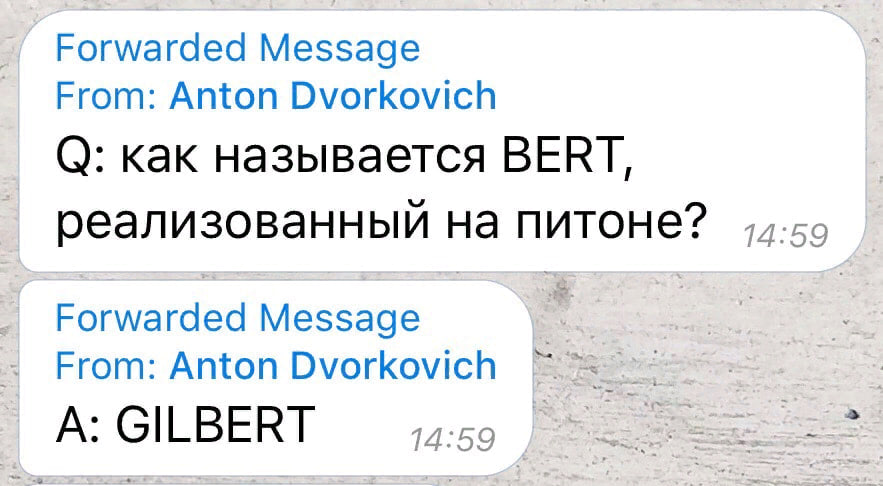

## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [219]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

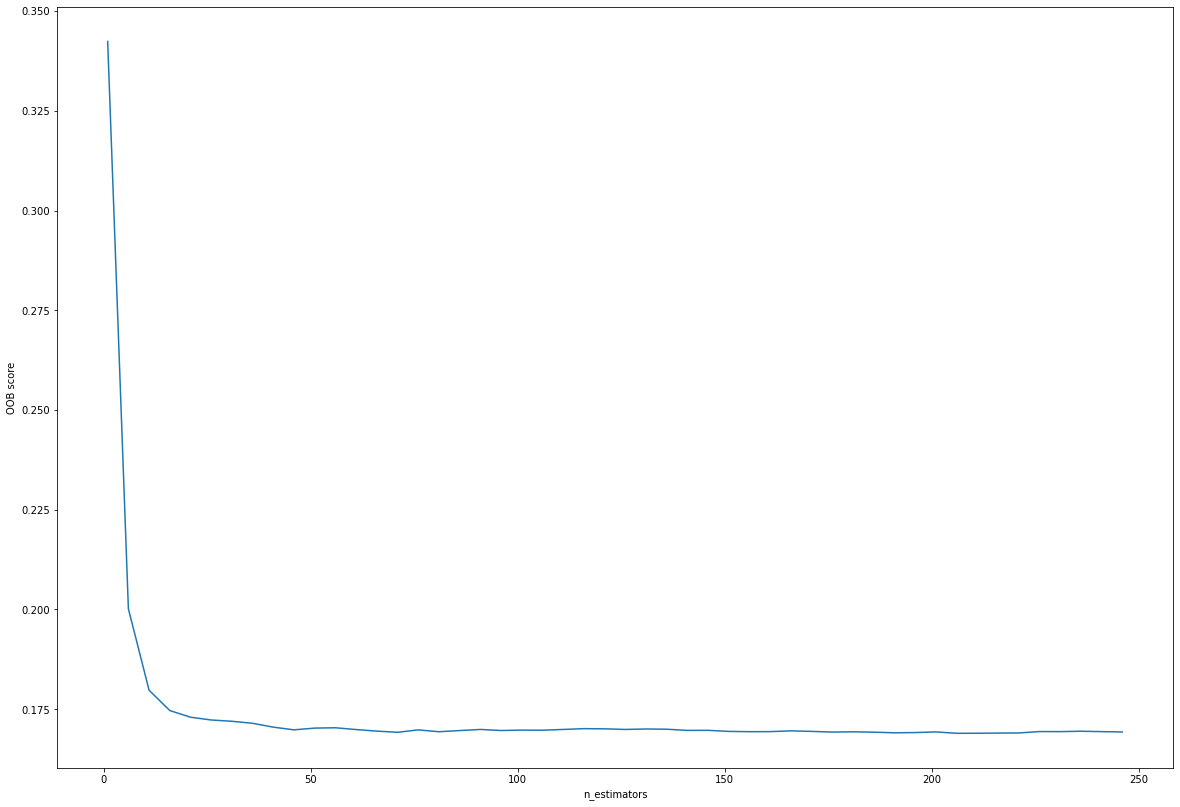

In [220]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной 

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

<AxesSubplot:>

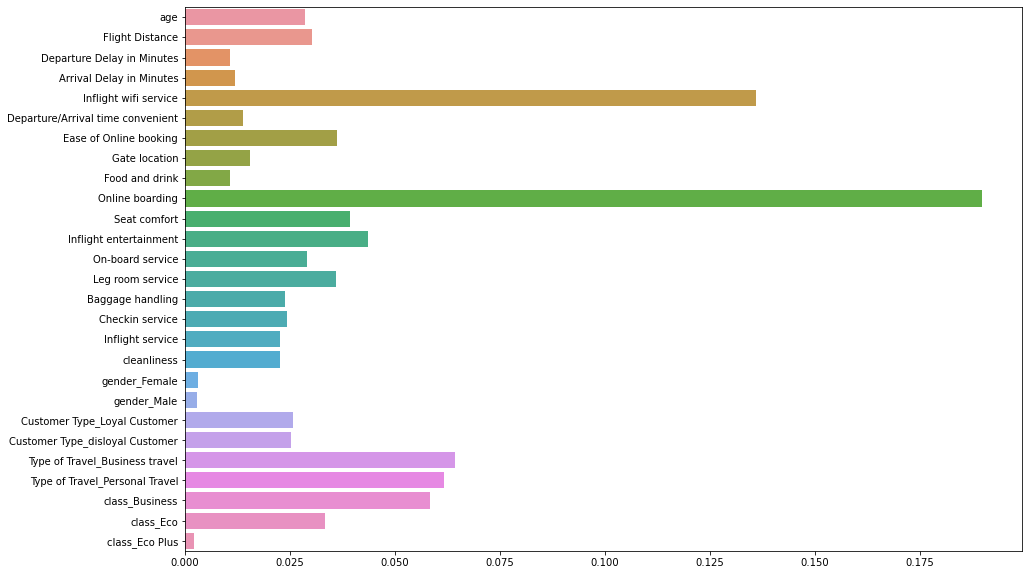

In [229]:
fig = plt.figure(figsize=(15, 10))
sns.barplot(x=rf.feature_importances_, y=rf.feature_names_in_)

(0.25 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [241]:
rf.feature_names_in_

array(['age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding',
       'Seat comfort', 'Inflight entertainment', 'On-board service',
       'Leg room service', 'Baggage handling', 'Checkin service',
       'Inflight service', 'cleanliness', 'gender_Female', 'gender_Male',
       'Customer Type_Loyal Customer', 'Customer Type_disloyal Customer',
       'Type of Travel_Business travel', 'Type of Travel_Personal Travel',
       'class_Business', 'class_Eco', 'class_Eco Plus'], dtype=object)

In [250]:
feats_importances = pd.DataFrame(data=np.array([rf.feature_names_in_, rf.feature_importances_]).T, 
                                 columns=['feature', 'importance'])

In [251]:
feats_importances['model'] = 'random forrest'

In [255]:
feats_importances = pd.concat([feats_importances, 
           pd.DataFrame(data=np.array([X_train_ohe.columns, tree_model.feature_importances_, 
                                       ['single tree' for _ in range(len(tree_model.feature_importances_))]]).T, 
                        columns=['feature', 'importance', 'model'])], axis=0)

<AxesSubplot:xlabel='importance', ylabel='feature'>

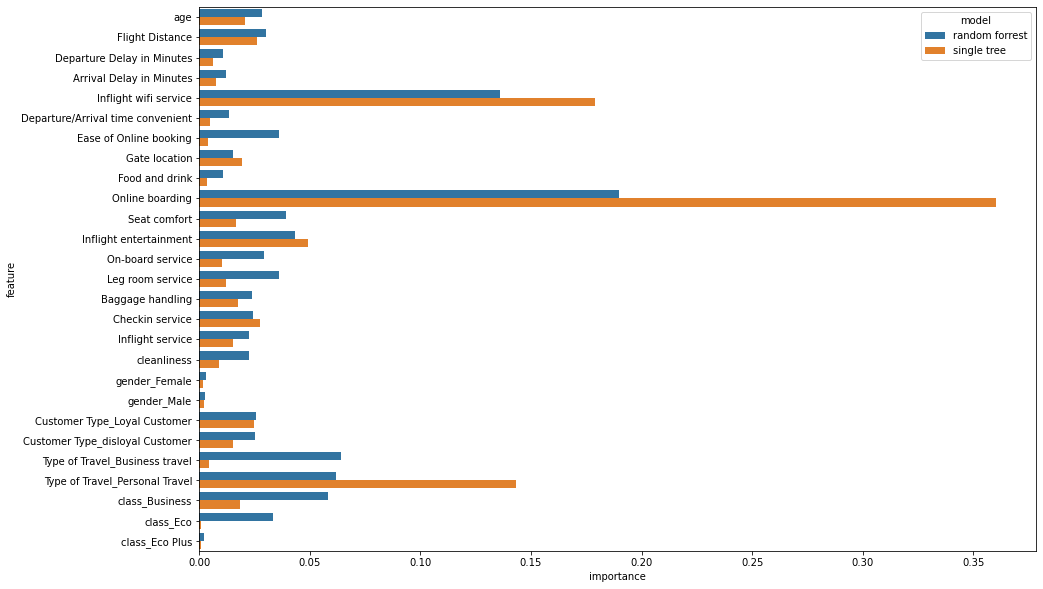

In [258]:
fig = plt.figure(figsize=(15, 10))
sns.barplot(data=feats_importances, y='feature', x='importance', hue='model')

(0.25 балла) <font color='#9933CC'>Оцените Permutation Importance вашео случайного леса</font>. Загляните в [документацию библиотеки eli5](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)

In [275]:
permutation = PermutationImportance(estimator=rf, random_state=42)
permutation.fit(X_train_ohe, y_train)
eli5.explain_weights_sklearn(permutation, feature_names=X_train_ohe.columns.to_list())

Explanation(estimator='PermutationImportance(estimator=RandomForestClassifier(), random_state=42)', description="\nFeature importances, computed as a decrease in score when feature\nvalues are permuted (i.e. become noise). This is also known as \npermutation importance.\n\nIf feature importances are computed on the same data as used for training, \nthey don't reflect importance of features for generalization. Use a held-out\ndataset if you want generalization feature importances.\n", error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='Inflight wifi service', weight=0.14264736790483265, std=0.0003097311578897884, value=None), FeatureWeight(feature='Online boarding', weight=0.04819179195449006, std=0.0006197284813512468, value=None), FeatureWeight(feature='Checkin service', weight=0.03194664350067959, std=0.0007265028657752167, value=None), FeatureWeight(feature='Baggage handling', weight=0.025840350852611094, std=0.0005424820971537865, value=None), FeatureWeight(feature='Inflight service', weight=0.02535554652580254, std=0.0003333014560698338, value=None), FeatureWeight(feature='Seat comfort', weight=0.022959548263251573, std=8.709815336023328e-05, value=None), FeatureWeight(feature='Type of Travel_Business travel', weight=0.018372122350039953, std=0.0003177163260194367, value=None), FeatureWeight(feature='cleanliness', weight=0.01657582423741404, std=0.0004151811680149209, value=None), FeatureWeight(feature='On-board service', weight=0.012529249393994602, std=0.00037465476532090423, value=None), FeatureWeight(feature='age', weight=0.012232201656181284, std=0.0004331401662969589, value=None), FeatureWeight(feature='class_Business', weight=0.01124017430537072, std=7.275290384197836e-05, value=None), FeatureWeight(feature='Leg room service', weight=0.009606411747397337, std=0.0004301929815402808, value=None), FeatureWeight(feature='Flight Distance', weight=0.009012316271770704, std=0.0002486669624232229, value=None), FeatureWeight(feature='Arrival Delay in Minutes', weight=0.007675601451610681, std=0.00022001470023558437, value=None), FeatureWeight(feature='Ease of Online booking', weight=0.006487410500357327, std=0.000132926522446802, value=None), FeatureWeight(feature='Inflight entertainment', weight=0.006212781459737427, std=0.0001968828827109779, value=None), FeatureWeight(feature='Customer Type_Loyal Customer', weight=0.00594095475626677, std=0.00022714494112749555, value=None), FeatureWeight(feature='Gate location', weight=0.00493771805685943, std=0.00017869157272127075, value=None), FeatureWeight(feature='Type of Travel_Personal Travel', weight=0.00482842690804135, std=0.0002654983375376262, value=None), FeatureWeight(feature='Departure Delay in Minutes', weight=0.004643472656195291, std=8.754781124472517e-05, value=None)], remaining=7), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

<font color='#FF6600'>Изучите документацию библиотеки eli5. Перечислите полезные инструменты из неё, которые вам хотелось бы попробовать: </font>

In [ ]:
# feel free to change this cell into markdown

# TODO:

(0.25 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [299]:
explainer = shap.TreeExplainer(rf)
random_objs = np.random.choice(X_train_ohe.index, size=1000, replace=False, random_state=42)
shap_values = explainer.shap_values(X_train_ohe.loc[random_objs])

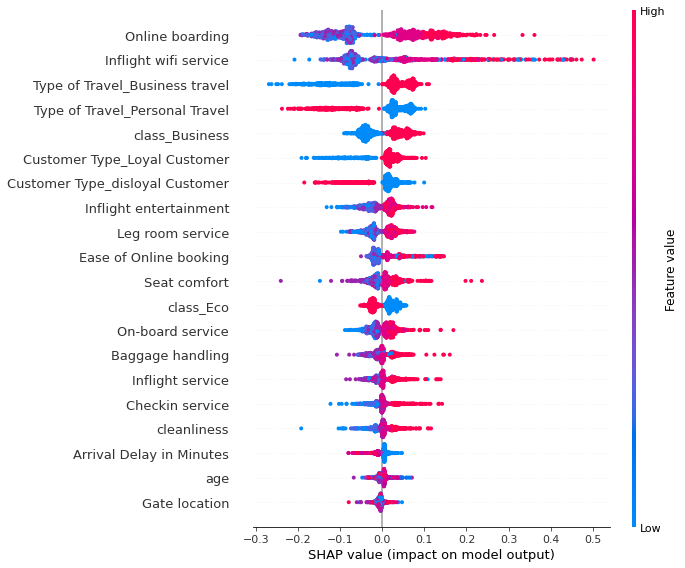

In [318]:
shap.summary_plot(shap_values[1], X_train_ohe.loc[random_objs], plot_type='dot')

<font color='#FF6600'>Опишите полученый график</font>

#### Видно, что если люди ставят высокие оценки порядковым параметрам типа стабильности вайфая, удобства сидений, и тд, то вероятно они остались довольны полетом, наоборот, если самолет опоздал в пункт назначения, то пассажир скорее всего будет недоволен

<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

#### Можно увидеть, почему конкретный пассажир поставил ту или иную оценку

(0.25 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [322]:
# please type your solution below

lime_explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train_ohe.to_numpy(),
                                                        feature_names=X_train_ohe.columns,
                                                        class_names=[0, 1])

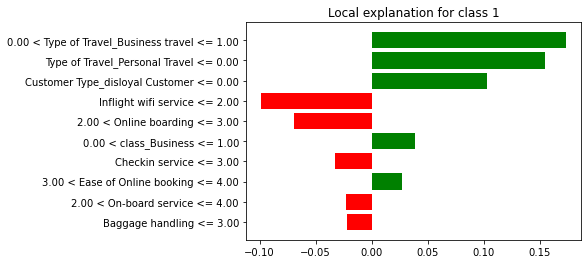

In [336]:
exp = lime_explainer.explain_instance(X_train_ohe.loc[0], rf.predict_proba)

fig = exp.as_pyplot_figure()

<font color='#FF6600'>Опишите полученый график</font>

#### Самая большая важность у типа поездки, лояльности пассажира, оценки вайфая и онлайн регистрации, выглядит логично

<font color='#9933CC'>Случайное дерево, дающее лучший скор, сохраните в pickle</font>

In [342]:
with open('rf.pkj', 'wb') as f:
    pickle.dump(rf, f)

# Бустинги (1 балл)

## CatBoost (0.25 балла)

(0.25 балла) <font color='#9933CC'>Обучите pipeline из стандартизации континуальных (как договаривались) признаков и `CatBoostClassifier` с параметрами по умолчанию</font>. `StandardScaler` из sklearn не подойдет. Напишите свой собственный, который не будет изменять остальные фичи.

In [394]:
class MyStandardScaler(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''

    def __init__(self, cols_to_transform):
        self.cols_to_transform = cols_to_transform
        self.cols_params = {}

    def fit(self, X, y=None):
        for col in self.cols_to_transform:
            mean = X[col].mean()
            std = X[col].std()
            self.cols_params[col] = {'mean': mean, 'std': std}
            
        return self

    def transform(self, X):
        X_ = X.copy()
        for col in self.cols_to_transform:
            params = self.cols_params[col]
            X_[col] = (X_[col] - params['mean']) / params['std']
        
        return X_
    
    def get_feature_names_out(self):
        pass

In [415]:
categorical_idx = [np.where(X_train.columns.to_numpy() == col)[0].tolist()[0] for col in categorical_cols]

In [418]:
continuous_transformer.fit_transform(X_train)[0]

array([-0.09210159643283787, 2.5072015368305642, 1.174807127316807,
       1.1807577107765483, 'Male', 'Loyal Customer', 'Business travel',
       'Business', 2.0, 4.0, 4.0, 4.0, 5.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0,
       1.0, 3.0, 4.0], dtype=object)

In [ ]:
[4, 5, 6, 7]

In [425]:
# cell for pipeline fit and predict
scaler = MyStandardScaler(continuous_cols)
scaler.set_output(transform='pandas')

# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)

continuous_transformer = ColumnTransformer(transformers=[
    ('continuous', scaler, continuous_cols)
], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')


catboost_pipe = Pipeline(steps=[
    ('preprocessing', continuous_transformer),
    ('catboost', CatBoostClassifier(cat_features=categorical_cols, silent=True))
])

catboost_pipe.fit(X_train, y_train)

pred_val = catboost_pipe.predict(X_val)

<font color='#9933CC'>Сохраните себе `feature_importances_` катбуста</font>. Дальше они вам пригодятся

In [444]:
# (•_•)

(pd.DataFrame(data={'col': X_train.columns, 'importance': catboost_pipe['catboost'].feature_importances_})
 .to_csv('catboost_feats_importances.csv', sep=';', index=False))

## XGBoost + optuna (0.5 балла)

<font color='#9933CC'>Обучите `XGBClassifier` с параметрами по умолчанию</font>

In [446]:
xgb = XGBClassifier()

xgb.fit(X_train_ohe, y_train)
pred_val = xgb.predict(X_val_ohe)

accuracy_score(y_val, pred_val)

0.9631590990814292

(0.5 балла) <font color='#9933CC'>Оптуной подберите лучшие гиперпараметры для XGBoost</font> 

Полезные ссылки: [тык1](https://optuna.readthedocs.io/en/stable/), [тык2](https://habr.com/ru/post/704432/)

In [482]:
# (•_•)
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 20)
    lr = trial.suggest_float('learning_rate', 1e-2, 1)
    gamma = trial.suggest_float('gamma', 1e-4, 1e-2)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    model = XGBClassifier(max_depth=max_depth, learning_rate=lr, random_state=42, 
                          n_estimators=n_estimators, gamma=gamma)
    
    model.fit(X_train_ohe, y_train)
    pred_val = model.predict(X_val_ohe)
    
    return accuracy_score(y_val, pred_val)

In [483]:
%%time
study = optuna.create_study(study_name="xgboost", direction='maximize')
study.optimize(objective, n_trials=10, )

[I 2023-02-07 20:45:55,987] A new study created in memory with name: xgboost
[I 2023-02-07 20:46:11,309] Trial 0 finished with value: 0.9575038409989867 and parameters: {'max_depth': 10, 'learning_rate': 0.9469416863631608, 'gamma': 0.003958005103872634, 'n_estimators': 271}. Best is trial 0 with value: 0.9575038409989867.
[I 2023-02-07 20:46:18,228] Trial 1 finished with value: 0.9634206139060508 and parameters: {'max_depth': 10, 'learning_rate': 0.11248696571253405, 'gamma': 0.002714649404839101, 'n_estimators': 113}. Best is trial 1 with value: 0.9634206139060508.
[I 2023-02-07 20:46:36,338] Trial 2 finished with value: 0.9606420188944461 and parameters: {'max_depth': 11, 'learning_rate': 0.5331680797400723, 'gamma': 0.008638648669103612, 'n_estimators': 290}. Best is trial 1 with value: 0.9634206139060508.
[I 2023-02-07 20:46:46,752] Trial 3 finished with value: 0.9583537641790069 and parameters: {'max_depth': 20, 'learning_rate': 0.9017895827451108, 'gamma': 0.005659532068922049, 

CPU times: user 17min 42s, sys: 8.5 s, total: 17min 51s
Wall time: 2min 17s


In [484]:
study.best_params

{'max_depth': 10,
 'learning_rate': 0.11248696571253405,
 'gamma': 0.002714649404839101,
 'n_estimators': 113}

<font color='#9933CC'>Обучите XGBClassifier c подобранными гиперпараметрами</font>

In [485]:
xgb_best = XGBClassifier(
    **study.best_params,
    random_state=42
)
# code below

xgb_best.fit(X_train_ohe, y_train)
pred_val = xgb_best.predict(X_val_ohe)
accuracy_score(y_val, pred_val)

0.9634206139060508

<font color='#9933CC'>Сохраните себе `feature_importances_` xbgoost'а</font>. Дальше они вам пригодятся

In [486]:
xgb_best.feature_importances_

array([0.00481504, 0.00306944, 0.00259688, 0.00443134, 0.11220615,
       0.00458311, 0.00466719, 0.01348461, 0.00328086, 0.4369778 ,
       0.01251975, 0.04155228, 0.01129725, 0.01004626, 0.010226  ,
       0.0178107 , 0.0109592 , 0.01306441, 0.00245797, 0.        ,
       0.0498686 , 0.        , 0.17629342, 0.        , 0.04698431,
       0.00418037, 0.00262713], dtype=float32)

In [514]:
# code here

(pd.DataFrame(data={'col': X_train_ohe.columns, 'importance': xgb_best.feature_importances_})
 .to_csv('xgbm_feats_importances.csv', sep=';', index=False))

## LightGBM + Pipeline (0.25 балла)

(0.25 балла) И наконец, <font color='#9933CC'>обучите пайплайн из стандартизации признаков "Age" и "FlightDistance",  нормализации фичей "log_arrival_delay" и "log_departure_delay" и `LGBMClassifier` с параметрами по умолчанию</font>. Вам снова понадобится свой кастомный Scaler, который не будет трогать остальные фичи

In [490]:
class MyMinMaxScaler(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''

    def __init__(self, cols_to_transform):
        self.cols_to_transform = cols_to_transform
        self.params = {}

    def fit(self, X, y=None):
        for col in self.cols_to_transform:
            self.params[col] = {'min': X[col].min(), 'max': X[col].max()}
            
        return self

    def transform(self, X):
        X_ = X.copy()
        for col in self.cols_to_transform:
            # (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
            params = self.params[col]
            X_[col] = (X_[col] - params['min']) / (params['max'] - params['min'])
        
        return X_

In [493]:
X_train.columns

Index(['gender', 'age', 'Customer Type', 'Type of Travel', 'class',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness'],
      dtype='object')

In [495]:
for df in [X_train, X_train_ohe, X_val, X_val_ohe]:
    df.rename(columns={'Arrival Delay in Minutes': 'log_arrival_delay',
                       'Departure Delay in Minutes': 'log_departure_delay'}, inplace=True)

In [496]:
min_max = MyMinMaxScaler(cols_to_transform=['log_arrival_delay', "log_departure_delay"])

In [499]:
min_max.fit_transform(X_train)['log_departure_delay'].max()

1.0

In [506]:
pipe = [
    ('std_scaling', MyStandardScaler(cols_to_transform=['age', "Flight Distance"])),
    ('min_max', MyMinMaxScaler(cols_to_transform=['log_arrival_delay', "log_departure_delay"])),
    ('lgbm', LGBMClassifier())
]
lgbm_pipeline = Pipeline(pipe)

# your solution goes below

lgbm_pipeline.fit(X_train_ohe, y_train)
pred_val = lgbm_pipeline.predict(X_val_ohe)

accuracy_score(y_val, pred_val)

0.9632244777875846

<font color='#9933CC'>Сохраните себе `feature_importances_` lgbm'а</font>. Дальше они вам пригодятся

In [513]:
# code here
(pd.DataFrame(data={'col': X_train_ohe.columns, 'importance': lgbm_pipeline['lgbm'].feature_importances_})
 .to_csv('lgbm_feats_importances.csv', sep=';', index=False))

<font color='#9933CC'>Сохраните получившиеся бустинги (лучший xgboost, lgmb и catboost) в pickle</font>

<img src='https://i.imgur.com/qBFSCjZ.jpg' height=500px>

In [515]:
# your code below
with open('catboost.pkl', 'wb') as f:
    pickle.dump(catboost_pipe, f)
with open('xgbm.pkl', 'wb') as f:
    pickle.dump(xgb_best, f)
with open('lgbm.pkl', 'wb') as f:
    pickle.dump(lgbm_pipeline, f)

# Стекинг (0.5 балла)

(0.25 балла) <font color='#9933CC'>Воспользуйтесь `StackingClassifier` из skearn для ансаблирования обученных вами к этому шагу моделей</font>

In [659]:
%%time
catboost_pipe_upd = Pipeline(steps=[
    ('scaler', MyStandardScaler(cols_to_transform=continuous_cols)),
    ('catboost', CatBoostClassifier(silent=True))
])
X_train_ohe['Departure Delay in Minutes'] = X_train_ohe['log_departure_delay']
X_train_ohe['Arrival Delay in Minutes'] = X_train_ohe['log_arrival_delay']

X_val_ohe['Departure Delay in Minutes'] = X_val_ohe['log_departure_delay']
X_val_ohe['Arrival Delay in Minutes'] = X_val_ohe['log_arrival_delay']

stacking_clf = StackingClassifier(estimators=[('catboost', catboost_pipe_upd), ('xgbm', xgb_best), 
                                              ('lgbm', lgbm_pipeline)])

stacking_clf.fit(X_train_ohe, y_train)
pred_val = stacking_clf.predict(X_val_ohe)
accuracy_score(y_val, pred_val)

CPU times: user 14min 26s, sys: 19.9 s, total: 14min 46s
Wall time: 1min 56s


0.963616750024517

<font color='#9933CC'>Посмотрим, откалиброваны ли полученные после стекинга вероятности</font>

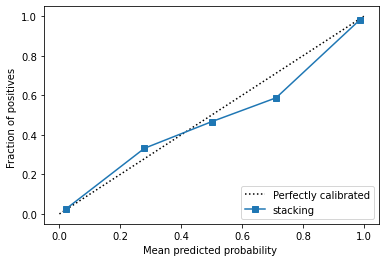

In [534]:
# -__-

y_prob = stacking_clf.predict_proba(X_val_ohe)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_prob, n_bins=5)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob, estimator_name='stacking')
disp.plot()

Неожиданно хорошо. Не так ли?

(0.25 балла) <font color='#9933CC'>Постройте ROC- и PR-кривые для полученной композиции. Также выведите другие метрики классификации: F1-score, precision, recall

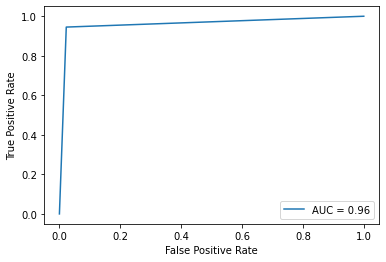

In [548]:
# the place for your solution
from sklearn.metrics import roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay

fpr, tpr, thresholds = roc_curve(y_val, pred_val)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

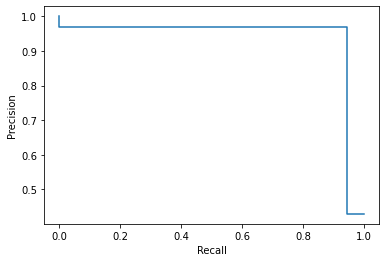

In [551]:
precision, recall, _ = precision_recall_curve(y_val, pred_val)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [552]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [553]:
print(f'F1 = {f1_score(y_val, pred_val)}')
print(f'precision = {precision_score(y_val, pred_val)}')
print(f'recall = {recall_score(y_val, pred_val)}')

F1 = 0.9570982538642407
precision = 0.969316052467208
recall = 0.9451846212409593


# Aftermath (1 балл)

В этом домашнем занятии до настоящей ячейки вы обучали модели на всех признаках из обучающей выборки. Давайте под конец попробуем избавиться от признаков, минимально влияющих на результат

Мы довольно часто выводили `feature_importances_` алгоритмов. Пробовали интерпретировать предсказания модели SHAP'ом. Неплохо бы структурировать и валидировать полученные знания.

(0.25 балла) <font color='#9933CC'>Создайте таблицу, в которой для сохраненных вами pickle'ом классификаторов в соответсвующих столбцах будут отранжированные по убыванию `feature_importances_` для этого конкретного классификатора.</font>

По такой таблице должно быть относительно удобно понять, какие признаки (в среднем для разных моделей) важнее остальных для предсказания целевой переменной

In [569]:
# (•_•)

feats_catboost = (pd.read_csv('catboost_feats_importances.csv', sep=';').sort_values('importance', ascending=False)
                 .reset_index(drop=True))
feats_lgbm = (pd.read_csv('lgbm_feats_importances.csv', sep=';').sort_values('importance', ascending=False)
             .reset_index(drop=True))
feats_xgbm = (pd.read_csv('xgbm_feats_importances.csv', sep=';').sort_values('importance', ascending=False)
             .reset_index(drop=True))

In [585]:
importances = feats_catboost.join(feats_lgbm, lsuffix='_catb', rsuffix='_lgbm')
importances = importances.join(feats_xgbm)

In [587]:
importances.rename(columns={'col': 'col_xgbm', 'importance': 'importance_xgbm'}, inplace=True)

In [588]:
importances

col_catb  importance_catb  \
0               Inflight wifi service        26.832441   
1          Departure Delay in Minutes        18.451991   
2                     Online boarding         7.062640   
3                     Flight Distance         6.778976   
4            Arrival Delay in Minutes         6.030721   
5                     Checkin service         3.620548   
6                              gender         3.581981   
7                    Baggage handling         3.363488   
8                        Seat comfort         3.280722   
9                       Gate location         3.256912   
10                   Inflight service         2.932736   
11             Inflight entertainment         2.923982   
12                   On-board service         2.000339   
13                                age         1.920433   
14                        cleanliness         1.762674   
15  Departure/Arrival time convenient         1.678014   
16             Ease of Online booking         1.674220   
17                   Leg room service         1.164562   
18                     Type of Travel         0.844520   
19                      Customer Type         0.409294   
20                     Food and drink         0.288984   
21                              class         0.139824   

                             col_lgbm  importance_lgbm  \
0               Inflight wifi service              500   
1                                 age              260   
2        Customer Type_Loyal Customer              199   
3                     Flight Distance              174   
4                    Baggage handling              170   
5      Type of Travel_Business travel              157   
6                     Online boarding              154   
7                      class_Business              148   
8                       Gate location              145   
9                        Seat comfort              140   
10                   Inflight service              135   
11                    Checkin service              115   
12             Inflight entertainment              112   
13                        cleanliness              104   
14                  log_arrival_delay               93   
15                   Leg room service               88   
16                   On-board service               74   
17  Departure/Arrival time convenient               65   
18             Ease of Online booking               62   
19                log_departure_delay               49   
20                     Food and drink               26   
21                          class_Eco                8   

                             col_xgbm  importance_xgbm  
0                     Online boarding         0.436978  
1      Type of Travel_Business travel         0.176293  
2               Inflight wifi service         0.112206  
3        Customer Type_Loyal Customer         0.049869  
4                      class_Business         0.046984  
5              Inflight entertainment         0.041552  
6                     Checkin service         0.017811  
7                       Gate location         0.013485  
8                         cleanliness         0.013064  
9                        Seat comfort         0.012520  
10                   On-board service         0.011297  
11                   Inflight service         0.010959  
12                   Baggage handling         0.010226  
13                   Leg room service         0.010046  
14                                age         0.004815  
15             Ease of Online booking         0.004667  
16  Departure/Arrival time convenient         0.004583  
17                  log_arrival_delay         0.004431  
18                          class_Eco         0.004180  
19                     Food and drink         0.003281  
20                    Flight Distance         0.003069  
21                     class_Eco Plus         0.002627

<font color='#FF6600'>Сделайте выводы: какие 3 признака скорее всего можно удалить?</font>

#### Food and drink, class, Departure/Arrival time convenient

### (0.25 балла) <font color='#9933CC'>Далее для отбора признаков воспользуемся статистическими тестами</font>. Попробуйте отобрать 20 наиболее информативных признака, используя `SelectKBest` из `sklearn.feature_selection`. В качестве статтестов примените (отдельно) `chi2` и `mutual_info_classif` 

In [601]:
# (•_•)

feat_selector = SelectKBest(k=20)
feat_selector.fit(X_train_ohe, y_train)

SelectKBest(k=20)

In [602]:
feat_selector.get_feature_names_out()

array(['age', 'Flight Distance', 'Inflight wifi service',
       'Ease of Online booking', 'Food and drink', 'Online boarding',
       'Seat comfort', 'Inflight entertainment', 'On-board service',
       'Leg room service', 'Baggage handling', 'Checkin service',
       'Inflight service', 'cleanliness', 'Customer Type_Loyal Customer',
       'Customer Type_disloyal Customer',
       'Type of Travel_Business travel', 'Type of Travel_Personal Travel',
       'class_Business', 'class_Eco'], dtype=object)

In [611]:
len(X_train_ohe.columns)

29

In [614]:
pd.DataFrame({'col': X_train_ohe.columns,
              'chi2': chi2(X_train_ohe, y_train)[0]}).sort_values('chi2', ascending=False).iloc[-9:]

col         chi2
6              Ease of Online booking  1463.584310
2                 log_departure_delay   806.817252
27         Departure Delay in Minutes   806.817252
26                     class_Eco Plus   705.857930
20       Customer Type_Loyal Customer   457.684773
5   Departure/Arrival time convenient   150.458478
19                        gender_Male     5.961210
18                      gender_Female     5.815830
7                       Gate location     0.070956

In [619]:
pd.DataFrame({'col': X_train_ohe.columns,
              'mutural_info': mutual_info_classif(X_train_ohe, y_train)}).sort_values('mutural_info', 
                                                                                         ascending=False).iloc[-9:]

col  mutural_info
7                       Gate location      0.011440
18                      gender_Female      0.009539
28           Arrival Delay in Minutes      0.007193
26                     class_Eco Plus      0.005853
3                   log_arrival_delay      0.005586
5   Departure/Arrival time convenient      0.004108
19                        gender_Male      0.003948
27         Departure Delay in Minutes      0.002499
2                 log_departure_delay      0.000771

<font color='#FF6600'>Согласуются ли списки признаков-кандитатов на удаление?</font>

#### Не совсем((

(0.25 балла)<font color='#9933CC'>Теперь применим жадные методы отбора признаков</font>. Воспользуйтесь классом `RFECV` для этого. <font color='#FF6600'>Сколько признаков были отобраны как наиболее информативные? Перечислите предложенные к удалению.</font>

In [622]:
# -____-

selector = RFECV(LGBMClassifier(), cv=3)
selector.fit(X_train_ohe, y_train)

RFECV(cv=3, estimator=LGBMClassifier())

In [631]:
selector.feature_names_in_[~selector.support_]

array(['log_departure_delay', 'Departure/Arrival time convenient',
       'Food and drink', 'gender_Female', 'gender_Male',
       'Customer Type_disloyal Customer',
       'Type of Travel_Personal Travel', 'class_Eco', 'class_Eco Plus',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
      dtype=object)

(0.25 балла) <font color='#9933CC'>C помощью логистической регрессией с L1-регуляризацией отберите >=5 неифнормативных признака</font>.

In [646]:
# -____-

lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
lr_l1.fit(X_train_ohe, y_train)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

In [647]:
pd.DataFrame({
    'feat': lr_l1.feature_names_in_, 'w': lr_l1.coef_[0]
})

feat         w
0                                 age -0.009763
1                     Flight Distance -0.000015
2                 log_departure_delay  0.000000
3                   log_arrival_delay -0.134136
4               Inflight wifi service  0.356876
5   Departure/Arrival time convenient -0.120035
6              Ease of Online booking -0.124925
7                       Gate location  0.000000
8                      Food and drink -0.029011
9                     Online boarding  0.579201
10                       Seat comfort  0.055887
11             Inflight entertainment  0.096778
12                   On-board service  0.276687
13                   Leg room service  0.238196
14                   Baggage handling  0.100463
15                    Checkin service  0.295794
16                   Inflight service  0.072793
17                        cleanliness  0.187114
18                      gender_Female -0.023765
19                        gender_Male  0.000000
20       Customer Type_Loyal Customer  0.000000
21    Customer Type_disloyal Customer -1.897523
22     Type of Travel_Business travel  0.000000
23     Type of Travel_Personal Travel -2.571569
24                     class_Business  0.000000
25                          class_Eco -0.767804
26                     class_Eco Plus -0.637995
27         Departure Delay in Minutes  0.000000
28           Arrival Delay in Minutes -0.058562

<font color='#9933CC'>Удалите 4 признака, которые считаете нужным удалить</font> <font color='#FF6600'>(если хотите больше -- пожалуйста, только обоснуйте целесообразность)</font>. <font color='#9933CC'>Обучите RandomForestClassifier с параметрами по умолчанию на этих признаках</font>. <font color='#FF6600'>Сильно ли уменьшилось качество на валидационной выборке? О чем это говорит?</font>

In [649]:
# -___-

X_train_final = X_train_ohe.drop(['Food and drink',  'Departure/Arrival time convenient', 
                                  'gender_Female', 'gender_Male'], axis=1)
X_val_final = X_val_ohe.drop(['Food and drink', 'Departure/Arrival time convenient', 
                              'gender_Female', 'gender_Male'], axis=1)

rf_final = RandomForestClassifier()
rf_final.fit(X_train_final, y_train)

pred_val = rf_final.predict(X_val_final)
accuracy_score(y_val, pred_val)

0.9616880781929326

#### метрика была 0.962, значит эти признаки все таки несут какое-то небольшое количество полезной информации

## Могли попросить, но не попросили (0 баллов, но >0 пользы).

Это домашнее задание уже получилось довольно объемным. Нам хотелось бы добавить ещё несколько (вообще говоря много) заданий -- однако хватит. Ниже некоторые из невошедших заданий

<font color='#29ab87'>На свое усмотрение выберите несколько (>= 3) классификаторов. На кросс-валидации переберите для каждого из них несколько (>=4) значений одного гиперпараметра. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра. На этом же графике изобразите доверительный интервал `[mean - std; mean + std]`</font>

<font color='#29ab87'>Для любой из модификаций бустинга (выберите себе по душе) постройте график ошибки композиции в зависимости от числа деревьев. Подберите гиперпараметр `n_estimators` по этому графику и обоснуйте свой выбор. Какую форму имеет получившаяся у вас ошибка на тесте? Согласуется ли это с теорией?</font>

<font color='#29ab87'>На модельном примере (для 2-х наиболее информативных "континуальных" признаков датасета этой домашки) покажите, как усложняется разделяющая поверхность композиции деревьев бустингом при добавлении в неё нового базового алгоритма, исправляющего ошибку предыдущего ансамбля</font>

<font color='#29ab87'>Постройте решающее дерево без каких-либо ограничений. Посчитайте качество на трейне и валидации. Сравнив их, сделайте выводы о переобучении. Примените какой-нибудь из методов pruning'а. Как изменилось дерево после разреживания (насколько меньше стало листов, изменилась ли глубина и пр.)? Сильно ли упало качество на трейне? Удалось ли перебороть переобучение?

# SQL INSERT (0.25 балла + 0.5)

В схеме `results` базы данных `db_flights` создано две таблицы:

1) `student_results` со столбцами:

```
* name (text)
* surname (text)
* best_algorithm (text)
* cv_score_best_algorithm (numeric(8,5))
* time_fit_best_algorithm (numeric(8,5))
* time_predict_best_algorithm (numeric(8,5))
```



2) `student_predictions` со столбцами:
```
* surname (text)
* id (integer)
* prediction (boolean)
```

У вас есть только возможность вставить данные в таблицу (INSERT), других прав на эту таблицу у вас нет.

**Задание 1 (0.25 балла), БЛОК!!!** <font color='#9933CC'> Вставьте одну строку в таблицу `student_results`, содержащую ваше имя, фамилию, название лучшего сработавшего у вас алгоритма, качество (accuracy) этого алгоритма на кросс-валидации, время обучения алгоритма и время применения алгоритма.</font>

**Задание 2 (0.5 балла), бонус** <font color='#9933CC'> Вставьте в таблицу `student_predictions` предсказания вашей наилучшей модели на тестовых данных. Число строк должно быть равно числу объектов в тестовых данных. В каждой строке столбца `surname` должна быть ваша фамилия, в столбце `id` - id объекта из тестовой выборки, в столбце `prediction` - предсказание вашей лучшей модели (класс).</font>


#### Считаю, как быстро применяется лучшая модель

In [651]:
%%time
pred_val = stacking_clf.predict(X_val_ohe)

CPU times: user 1.79 s, sys: 379 ms, total: 2.17 s
Wall time: 660 ms


In [652]:
from sklearn.model_selection import cross_val_score

In [653]:
X_ohe = pd.concat([X_train_ohe, X_val_ohe], axis=0)
y = pd.concat([y_train, y_val], axis=0)

cv_score = cross_val_score(stacking_clf, X_ohe, y, cv=4)

In [660]:
name = 'Vladislav'
surname = 'Gerasimov'
best_algorithm = 'stacking'
cv_score_best_algorithm = 0.964
time_fit_best_algorithm = 60 + 56
time_predict_best_algorithm = 0.66

In [655]:
cv_score.mean()

0.9643879952922716

In [680]:
query = (f"insert into db_flights.results.student_results(name, surname, best_algorithm, cv_score_best_algorithm, "
         f"time_fit_best_algorithm, time_predict_best_algorithm) "
         f"values ('{name}', '{surname}', '{best_algorithm}', "
         f"{cv_score_best_algorithm}, {time_fit_best_algorithm}, {time_predict_best_algorithm})")

In [684]:
with psycopg2.connect(host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net', 
                      port=6432, 
                      sslmode='verify-full', 
                      dbname='db_flights', 
                      user='mlhs_student', 
                      password='mlhs_student', 
                      target_session_attrs='read-write') as conn:
    with conn.cursor() as cur:
        cur.execute(query)
        conn.commit()

In [694]:
X_test = df_test.drop(categorical_cols, axis=1).join(
    pd.DataFrame(ohe_tree.fit_transform(df_test[categorical_cols]).toarray(), 
                 columns=ohe_tree.get_feature_names_out()))

In [695]:
X_test['log_departure_delay'] = X_test['Departure Delay in Minutes']
X_test['log_arrival_delay'] = X_test['Arrival Delay in Minutes']

In [701]:
X_test.columns = list(X_train_ohe.columns)

In [703]:
pred = stacking_clf.predict(X_test)

In [705]:
X_test['pred'] = pred

In [717]:
X_test.reset_index(inplace=True)

In [734]:
rows = ', '.join([f"('Gerasimov', {idx}, {bool(prediction)})" for idx, prediction in zip(X_test['index'], X_test['pred'])])

In [735]:
query = f"insert into db_flights.results.student_predictions values {rows}"

In [716]:
X_test['pred'].reset_index()

index  pred
0          16     1
1          19     0
2          34     1
3          43     1
4          48     1
...       ...   ...
25900  129515     1
25901  129536     0
25902  129540     0
25903  129544     0
25904  129545     0

[25905 rows x 2 columns]

In [737]:
with psycopg2.connect(host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net', 
                      port=6432, 
                      sslmode='verify-full', 
                      dbname='db_flights', 
                      user='mlhs_student', 
                      password='mlhs_student', 
                      target_session_attrs='read-write') as conn:
    with conn.cursor() as cur:
        cur.execute(query)
        conn.commit()

<img src='https://avatars.mds.yandex.net/get-images-cbir/1624848/cc-ejKx9OmtUbvaWx4cTNw1262/ocr' height=500px>

# Бонусная (+ 2.5 балла)

(0.5 балла) <font color='#9933CC'>Попробуйте различные знакомые вам подходы к  feature engineering</font>.

* Некоторые признаки возможно стоит бинаризовать. 
* Заполнять пропуски можно по-другому (умнее, чем мы сделали в начале)
* Можно добавить полиномы и другие фичи, попробовать воспользоваться методами снижения размерности и перейти в другое пространство признаков

*Известно, что скоррелированные признаки -- большая проблема почти для всех моделей машинного обучения. Значит, для стекинга важно, чтобы ответы базовых алгоритмов поменьше коррелировали между собой. Отчасти добиться этого можно добавлением в стекинг моделей разной природы. На соревнованиях по анализу табличных данных, например, в стекинг добавляют в т.ч. нейронные сети.*

(0.5 балла) <font color='#9933CC'>Добавьте в стекинг линейные и др. известные вам модели</font>. Не забудьте, что для них требуются другие пайплайны. Например, стандартизация признаков для деревянных моделей зачастую бессмысленна. Чего нельзя сказать о моделях линейных. <font color='#FF6600'>Позволил ли стекинг повысить качество по сравнению с лучшей его базовой моделью?</font>

(до 1.5 балла) <font color='#9933CC'>По 0.1 балла за каждую тысячную в скоре выше 0.962.</font>

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?